# Figures

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

In [3]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks


In [4]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [5]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [6]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [7]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    # df_span = df_span[['_200_' in f for f in df_span['file']]]
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [8]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/86 [00:00<?, ?it/s]

SPAN 85


file modification     cell  \
317  /home/jetbrains/data/2023_GSE26320/span/GSM646...      H3K4me3    Huvec   
104  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3     HMEC   
173  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...     H3K36me3     K562   
51   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3     HSMM   
143  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me3  GM12878   

    replicate   peaks         tool dataset  
317      rep1   23359         SPAN  ENCODE  
104      rep2  133755  MACS2 broad  ENCODE  
173      rep1   34144        SICER  ENCODE  
51       rep1     529        MACS2  ENCODE  
143      rep1   40073  MACS2 broad  ENCODE

In [9]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/50 [00:00<?, ?it/s]

SPAN 46


file modification      cell  \
73   /home/jetbrains/data/2023_Immune/macs2/Monocyt...     H3K27me3  Monocyte   
102  /home/jetbrains/data/2023_Immune/sicer/BCell_H...     H3K27me3     BCell   
34   /home/jetbrains/data/2023_Immune/macs2/TCell_H...     H3K36me3     TCell   
179  /home/jetbrains/data/2023_Immune/span/Monocyte...     H3K27me3  Monocyte   
164  /home/jetbrains/data/2023_Immune/span/PBMC_H3K...     H3K36me3      PBMC   

    replicate   peaks         tool  dataset  
73              63468  MACS2 broad  Roadmap  
102             50127        SICER  Roadmap  
34             183613        MACS2  Roadmap  
179             38153         SPAN  Roadmap  
164             24829         SPAN  Roadmap

In [10]:
df_peaks = pd.concat([df_encode_peaks, df_immune_peaks]).reset_index(drop=True)

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette usin

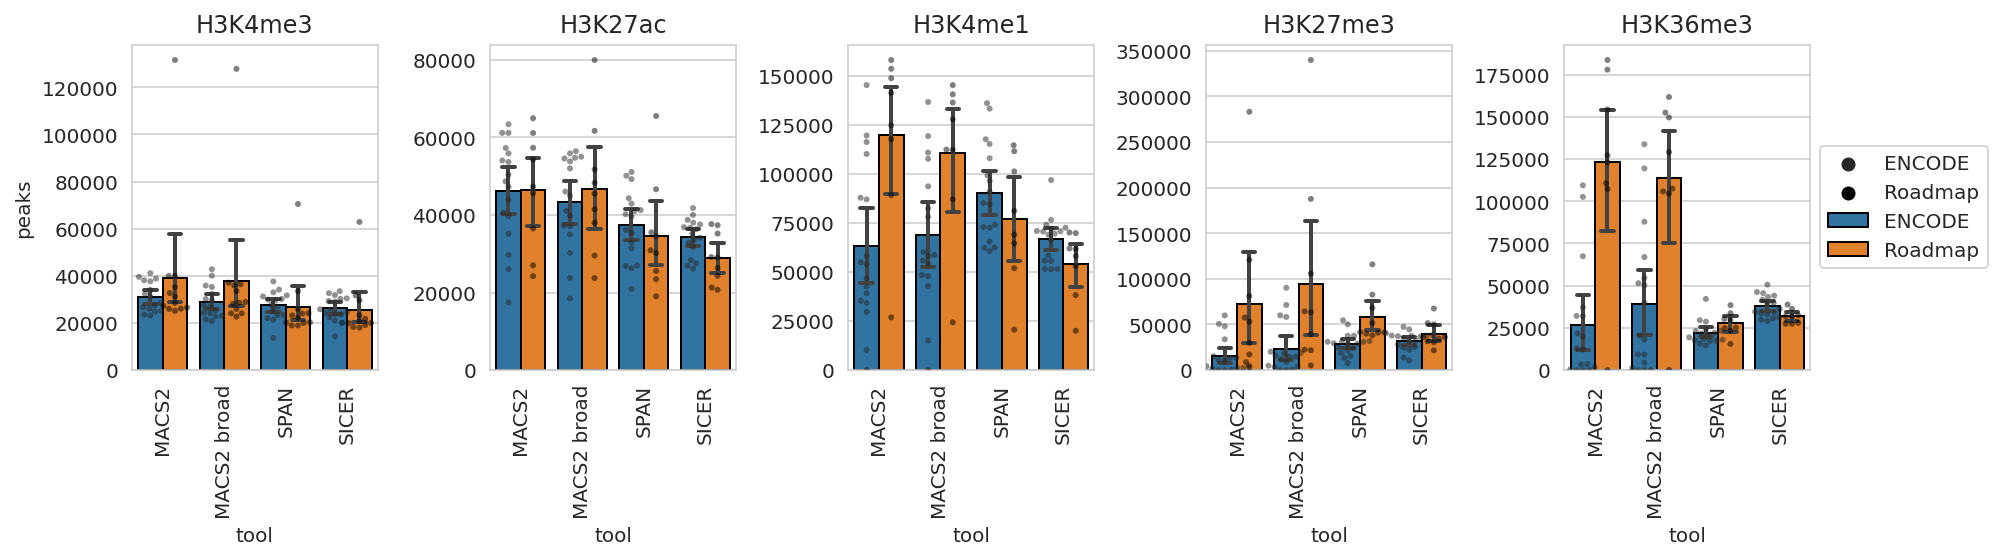

In [11]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
                capsize=.2, errwidth=2, edgecolor="black",
                # palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks',  hue='dataset',
                  dodge=True, size=3, color="black", alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

H3K4me3 ENCODE


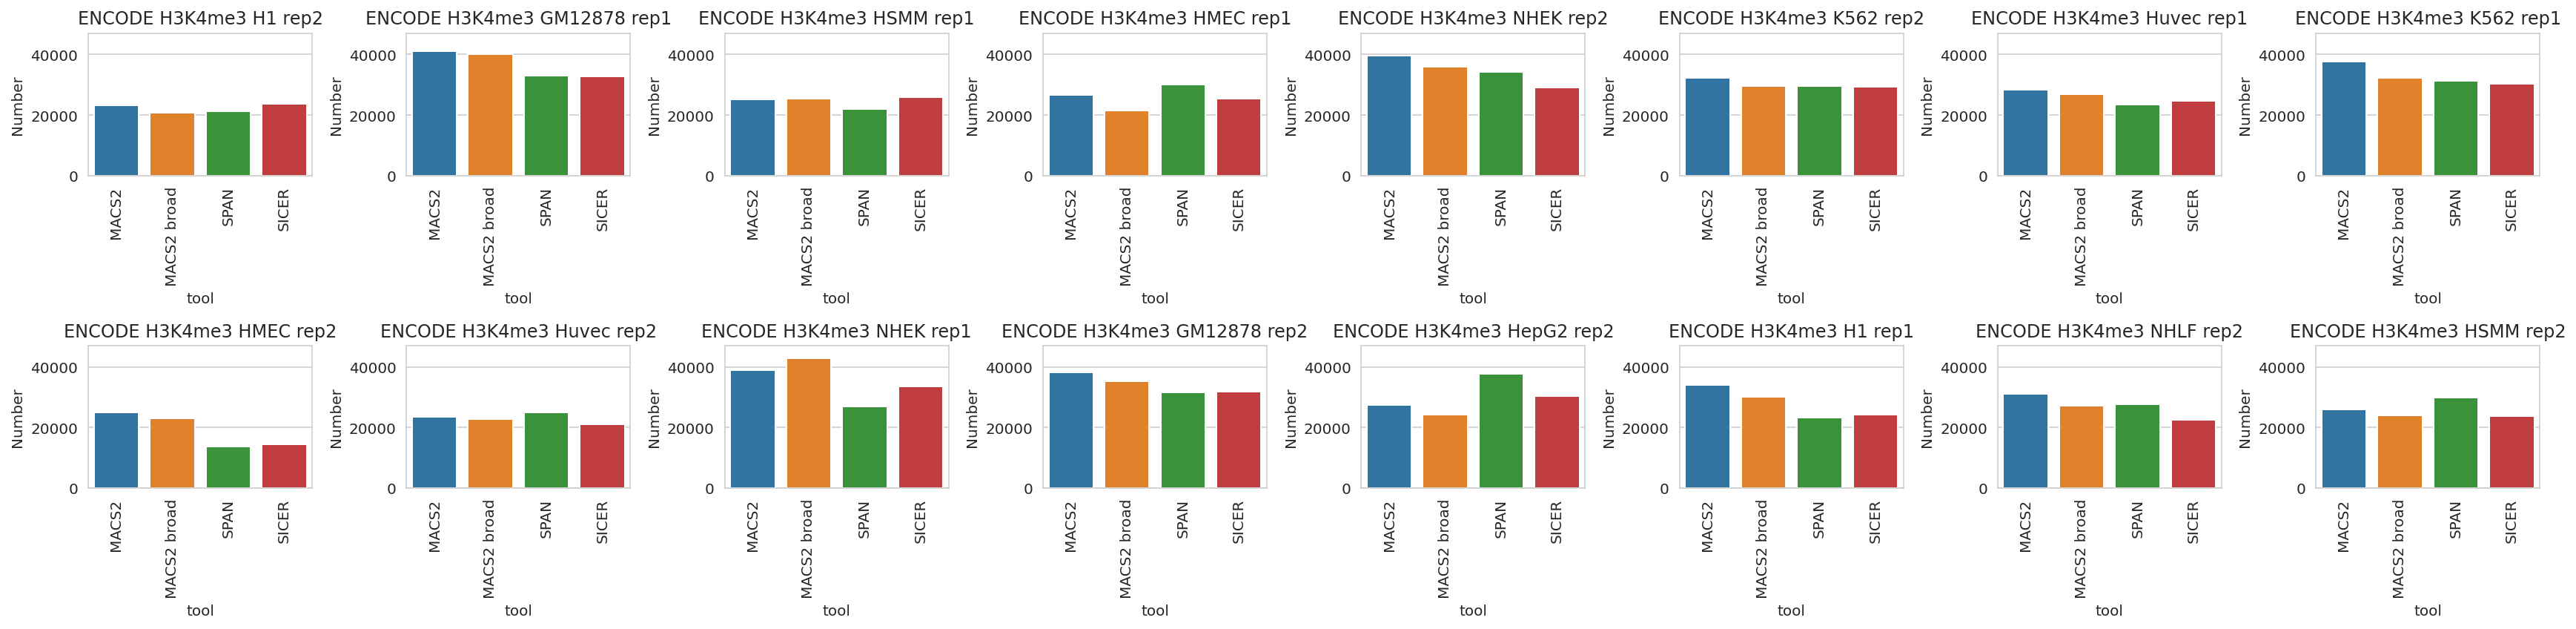

H3K4me3 Roadmap


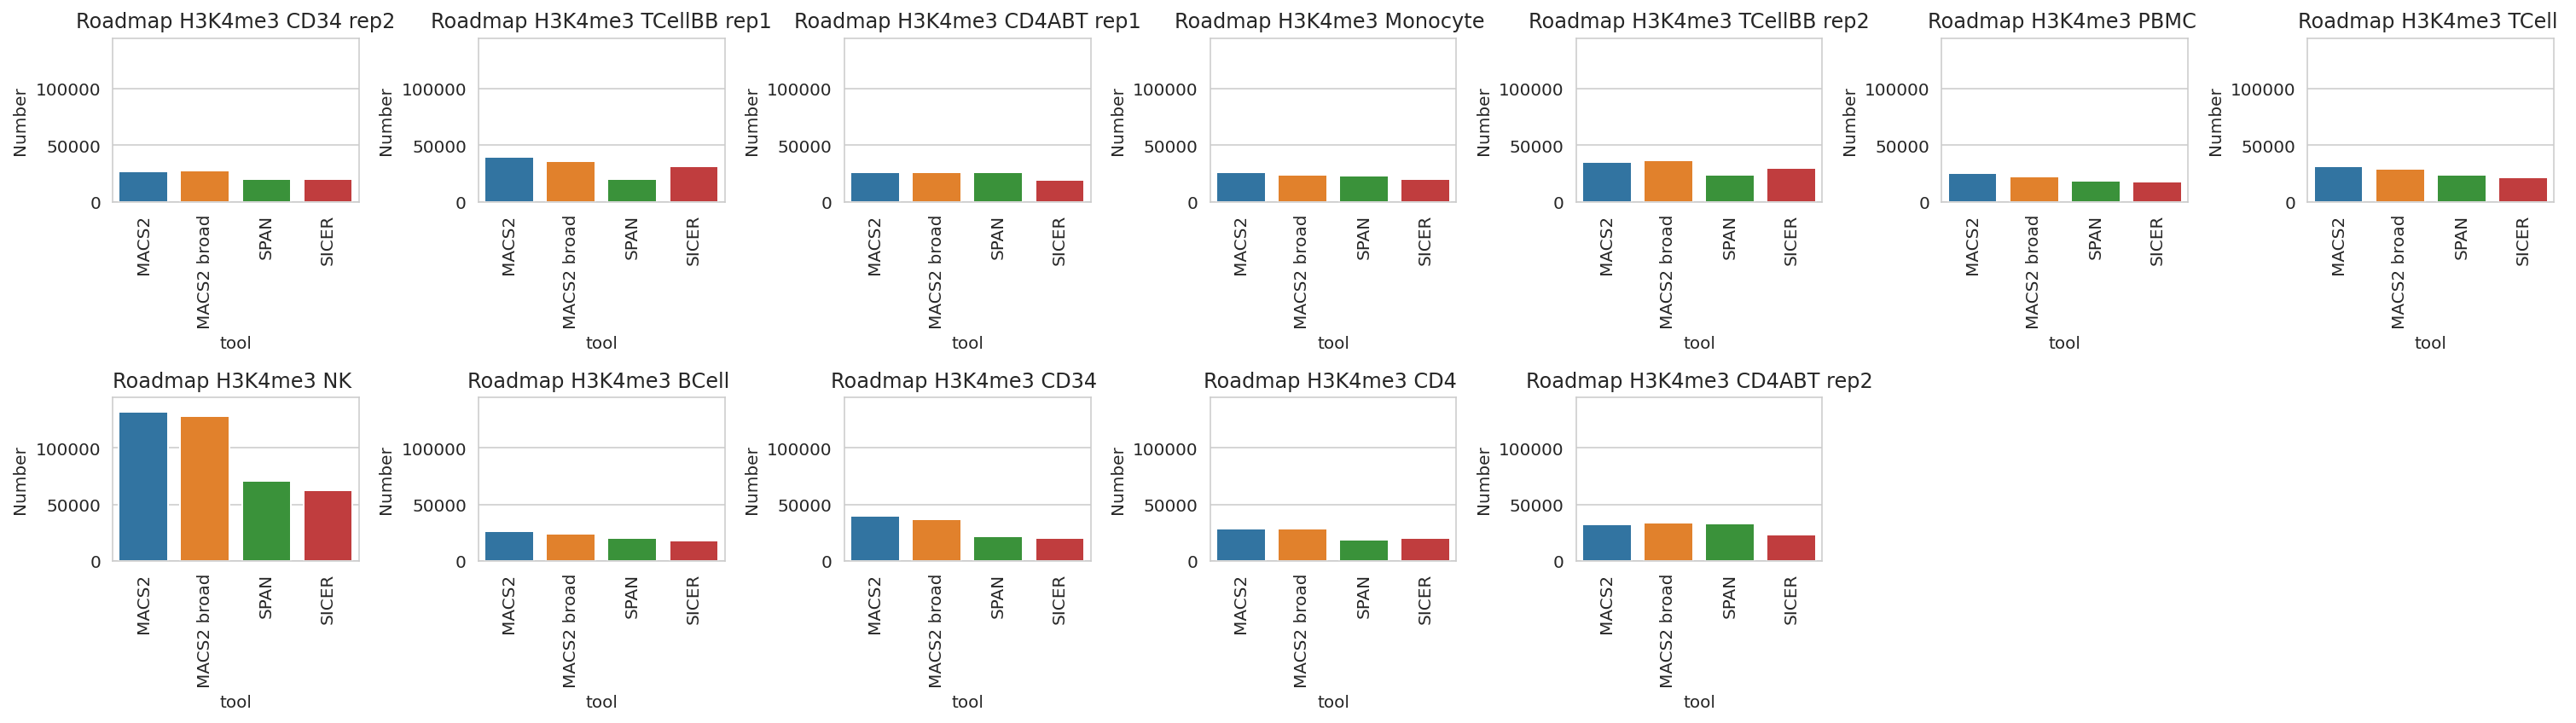

H3K27ac ENCODE


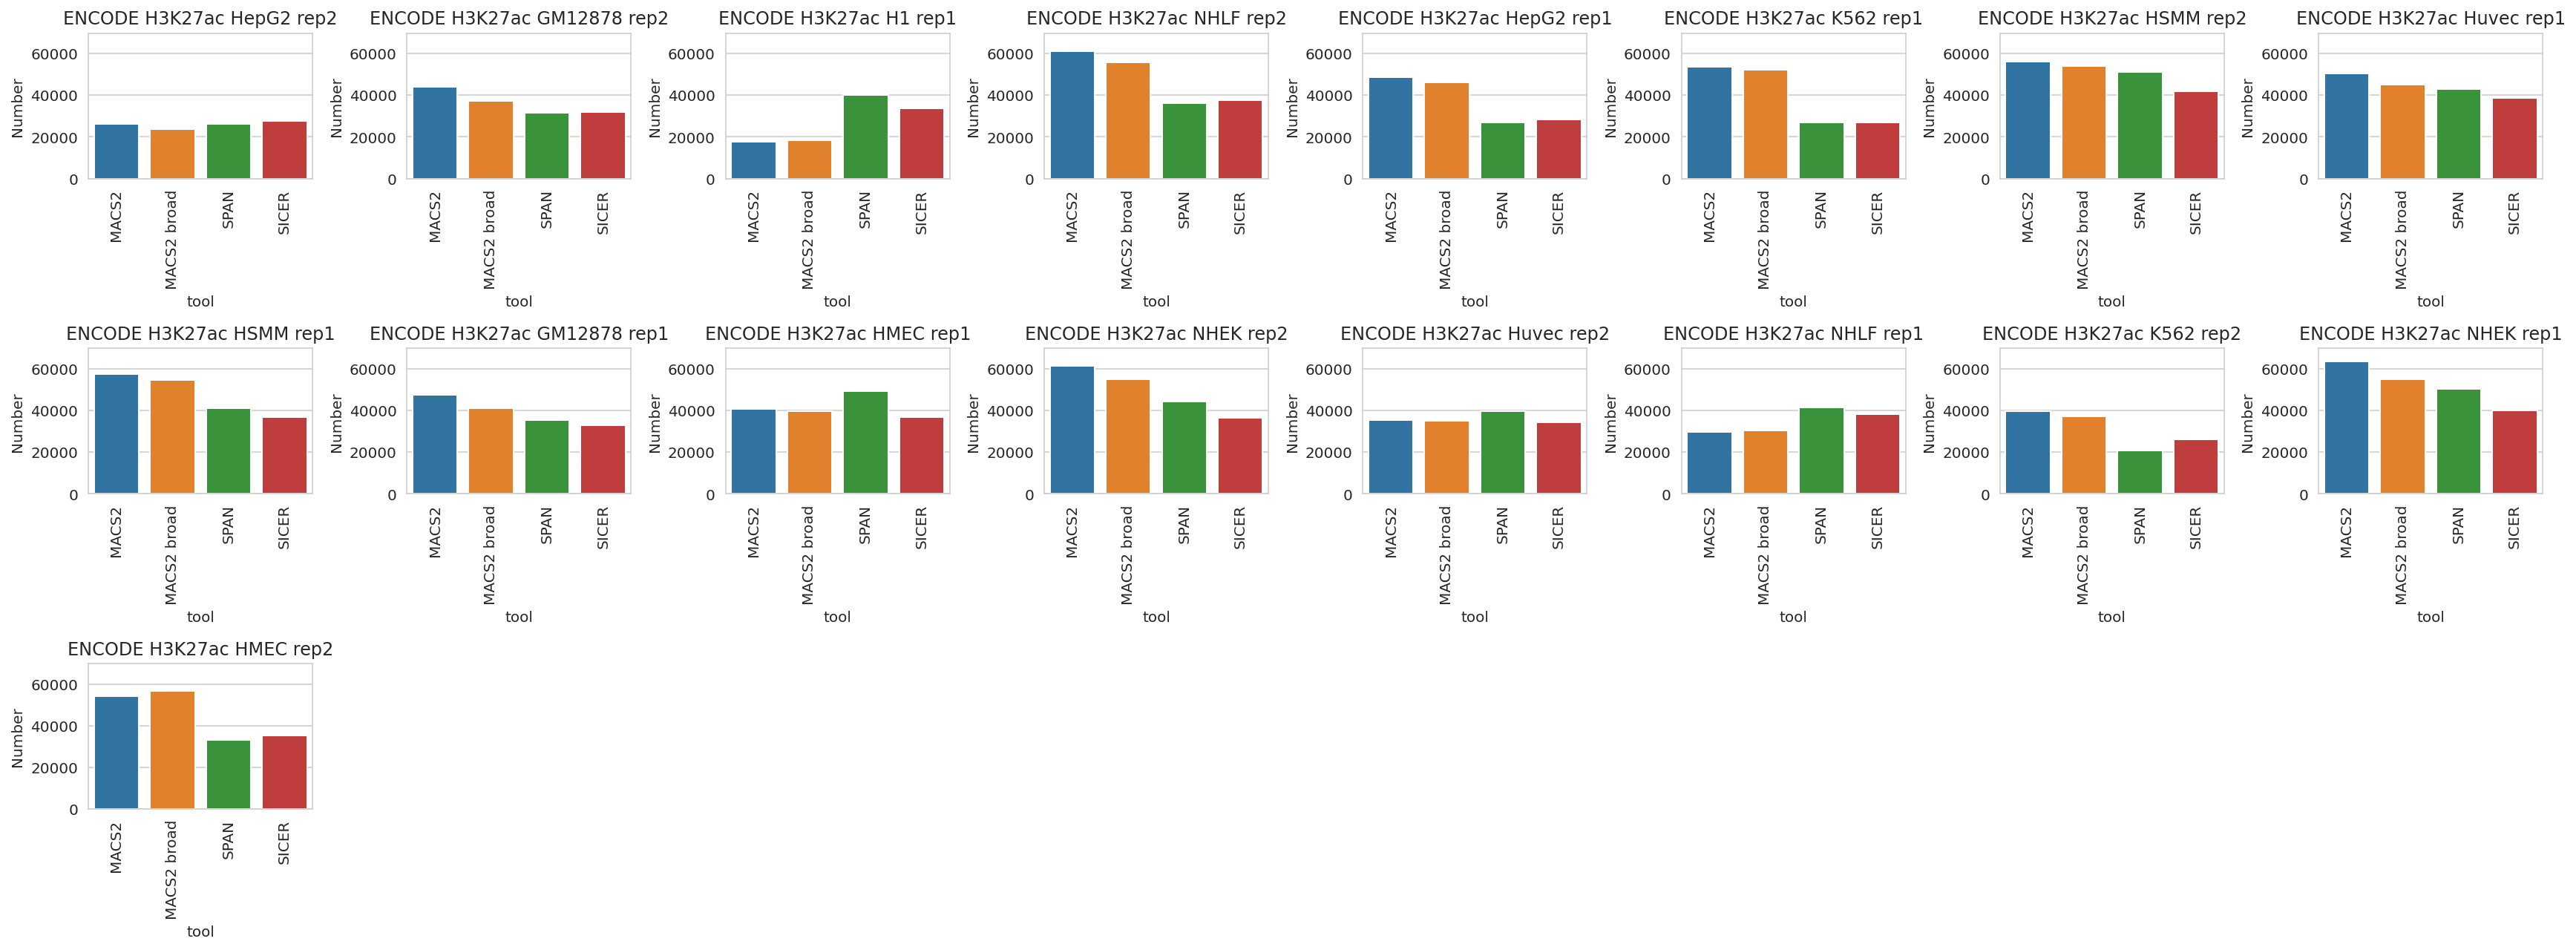

H3K27ac Roadmap


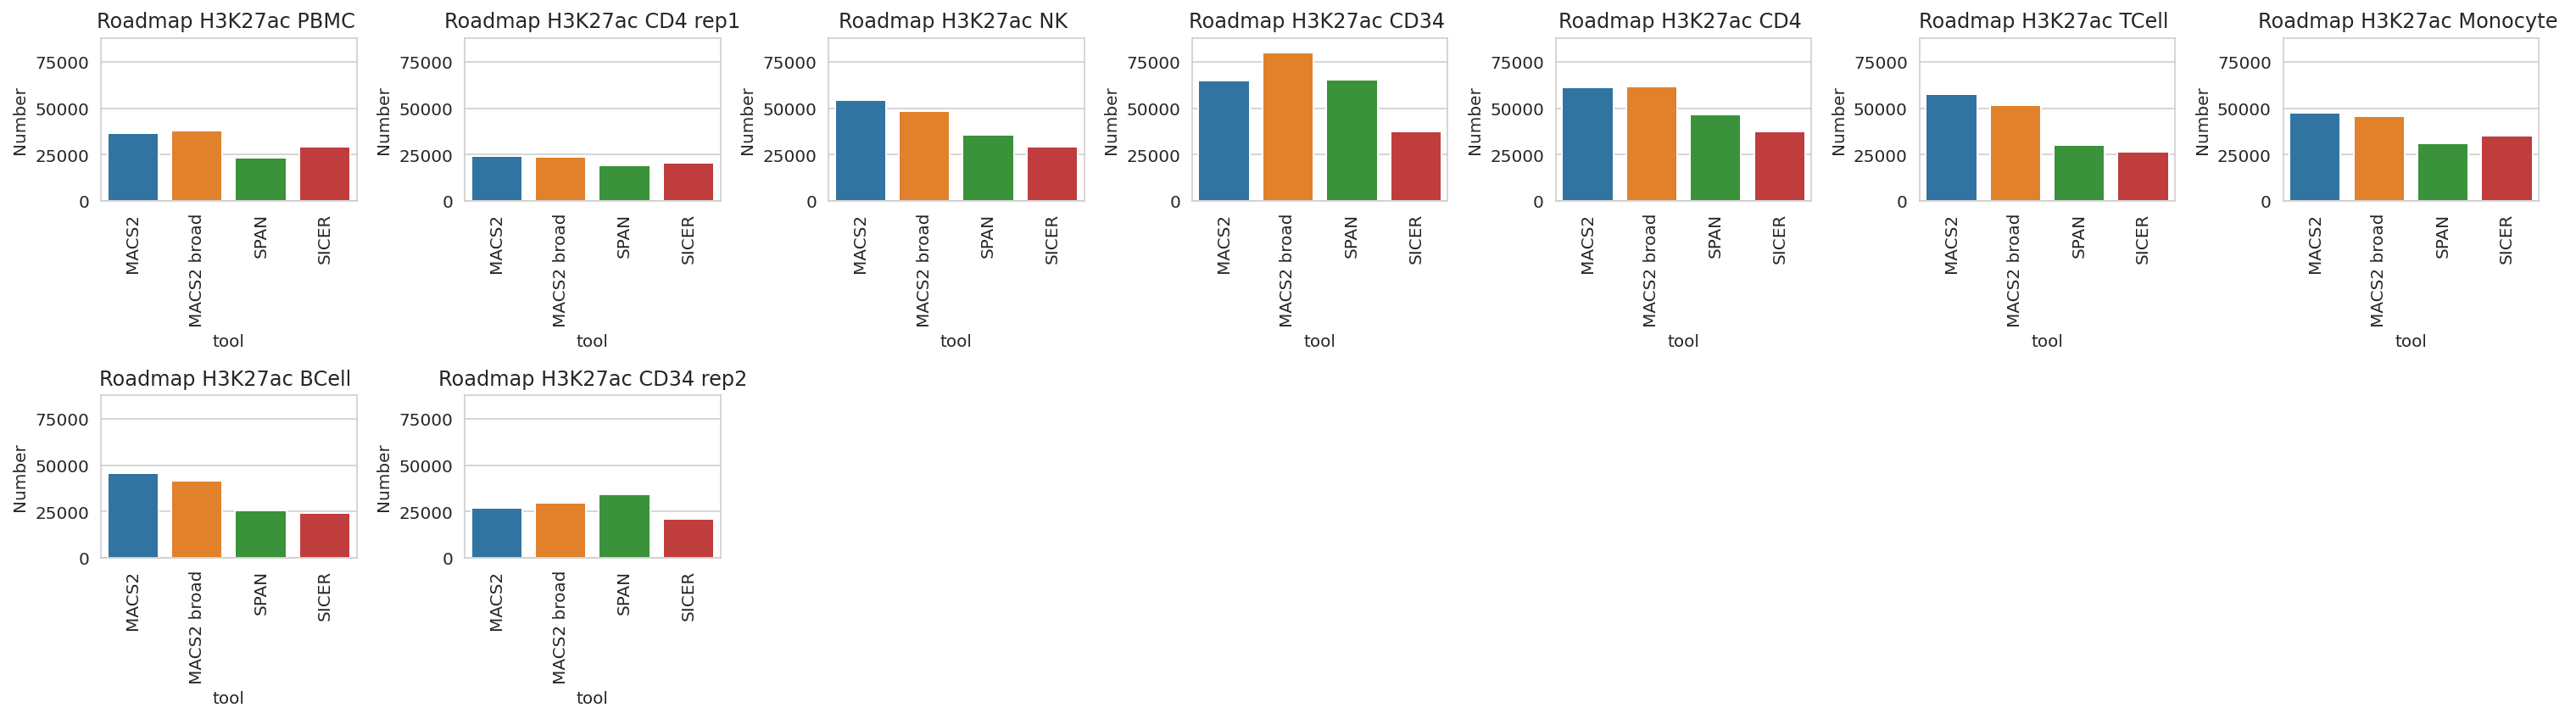

H3K4me1 ENCODE


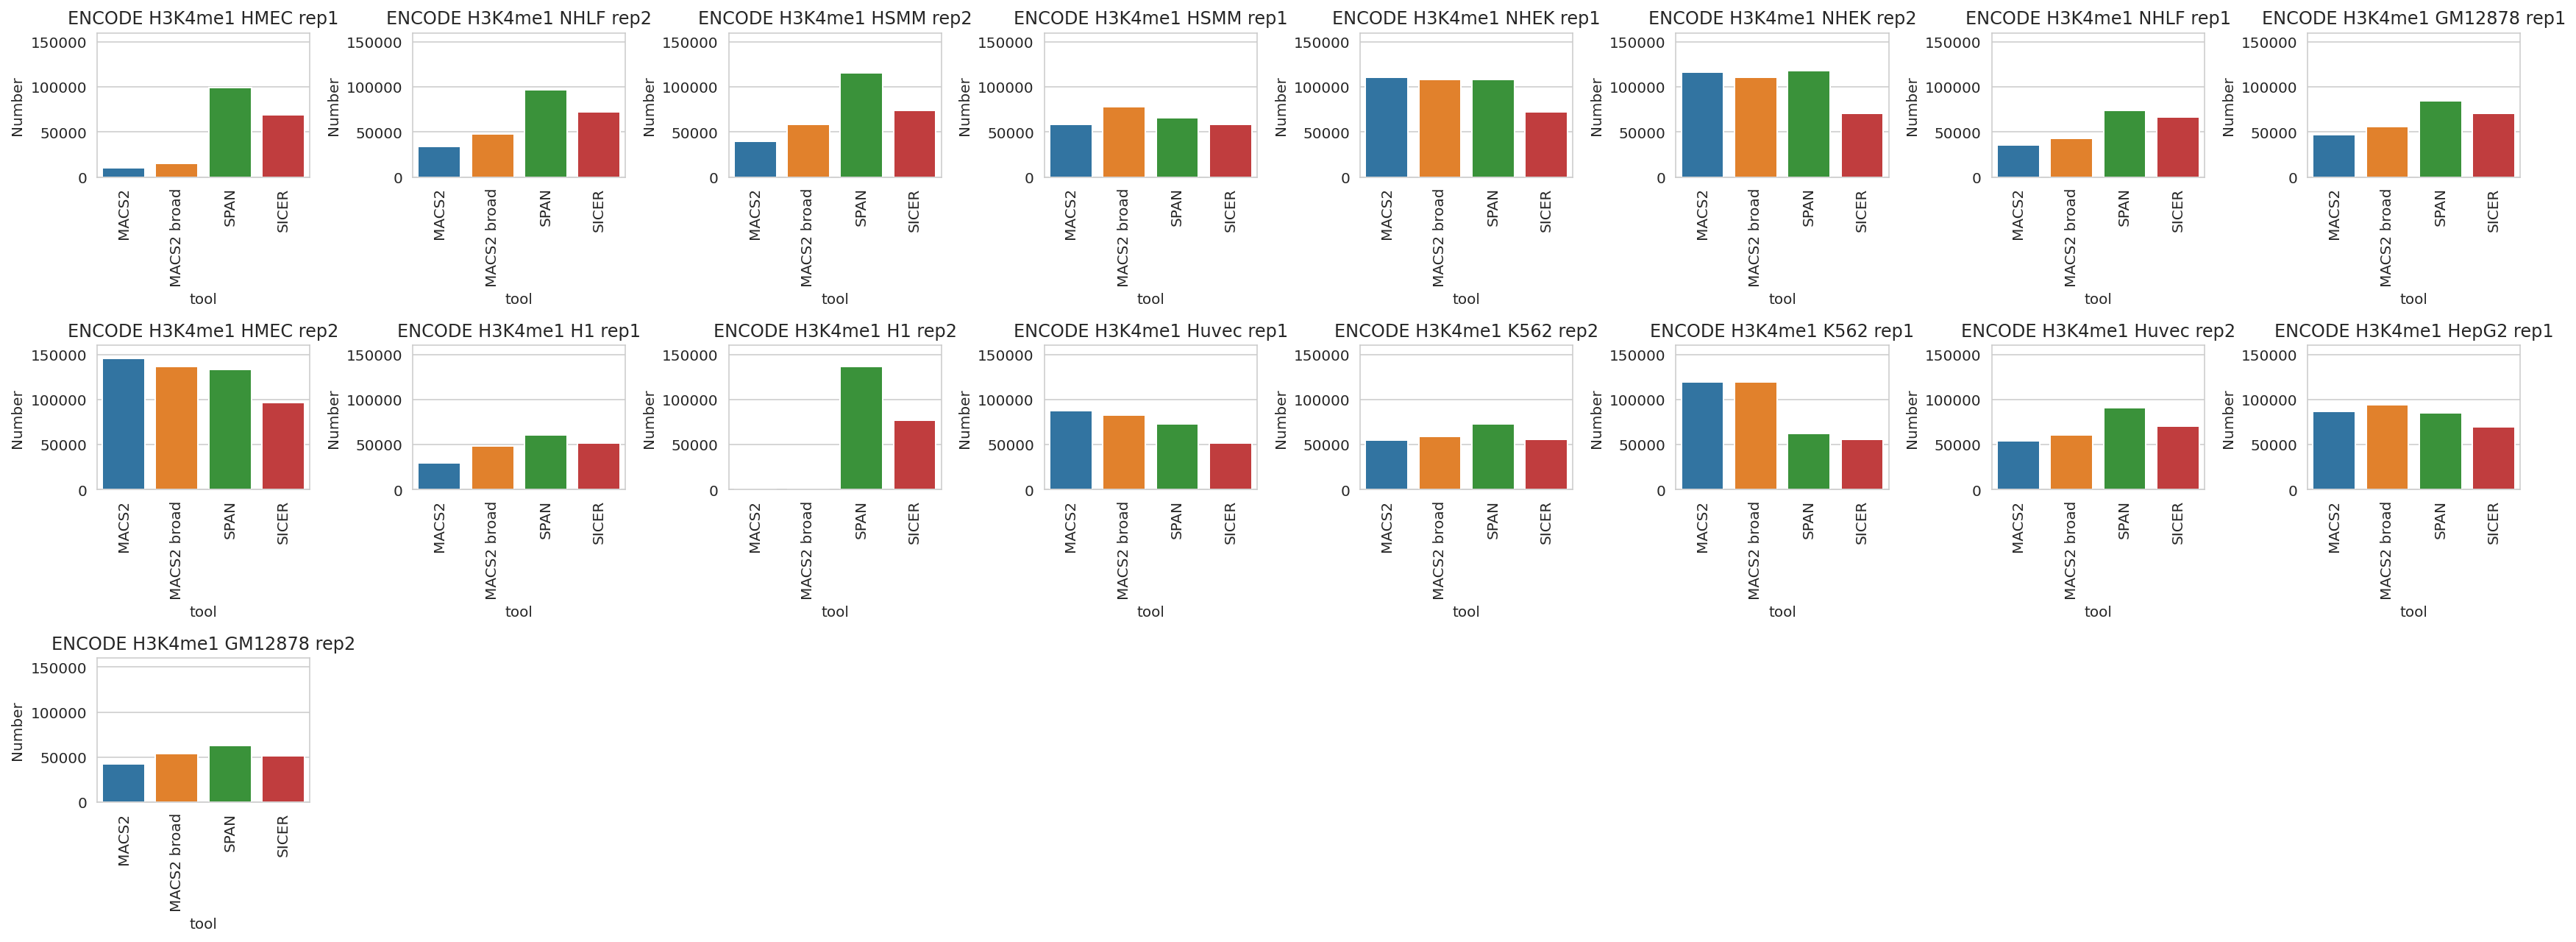

H3K4me1 Roadmap


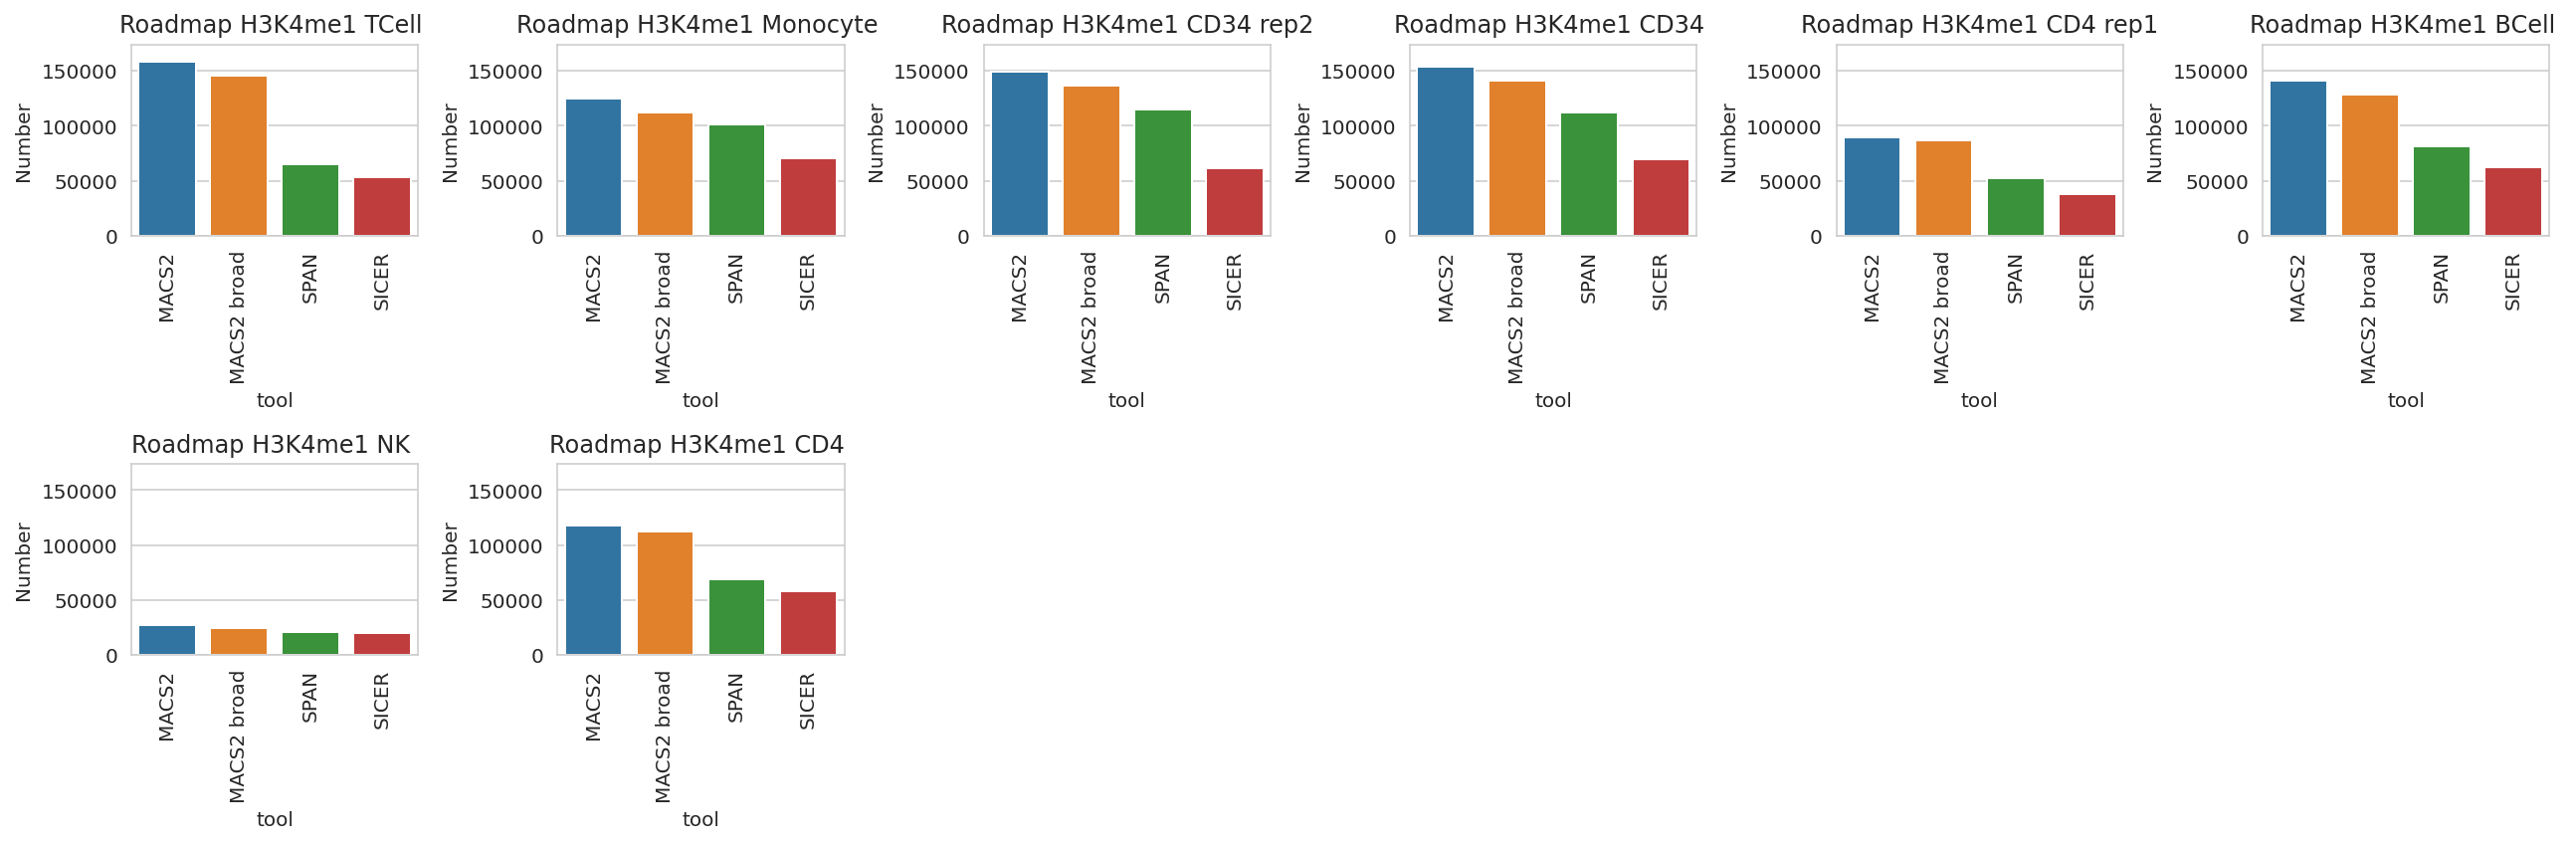

H3K27me3 ENCODE


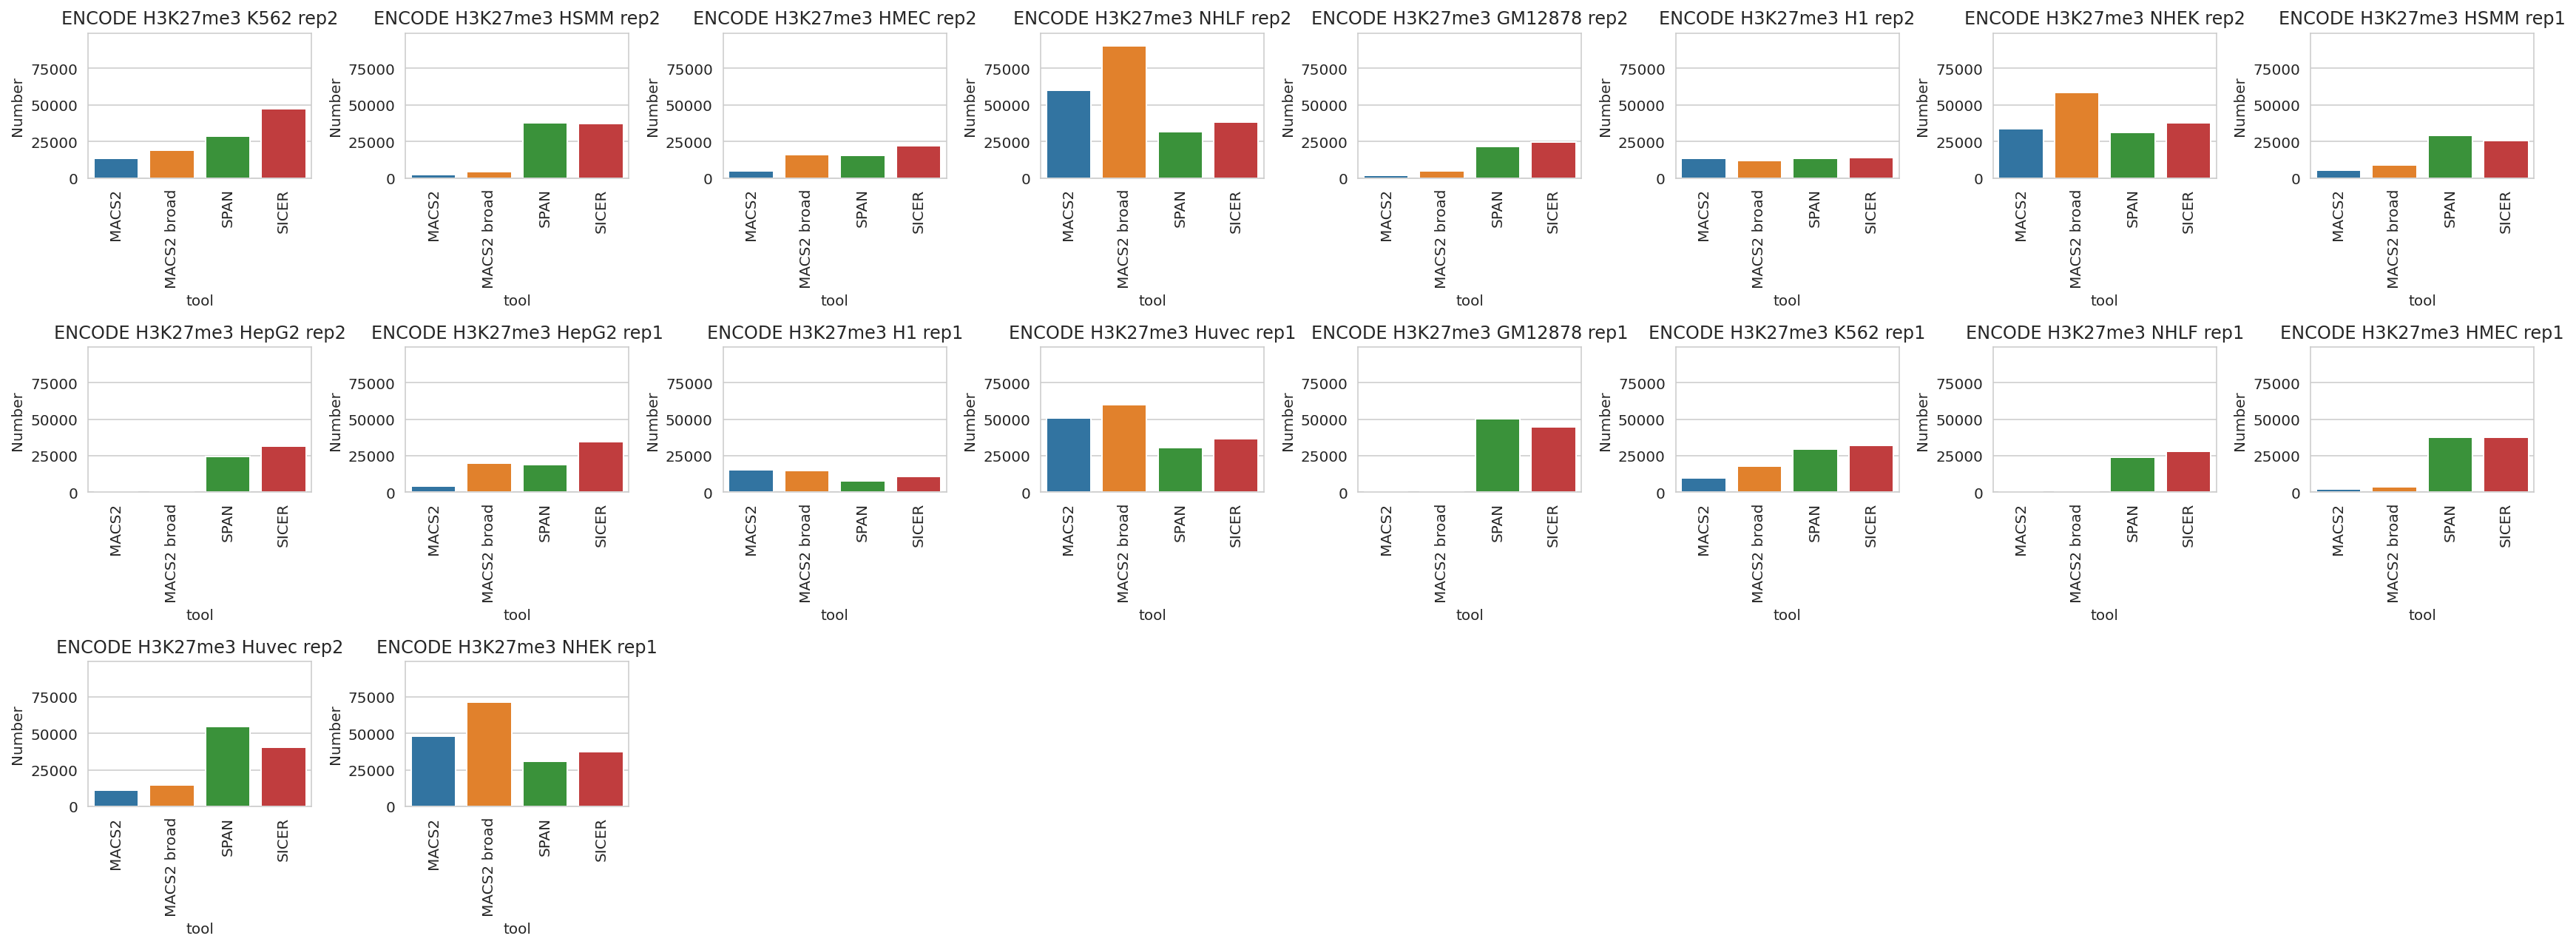

H3K27me3 Roadmap


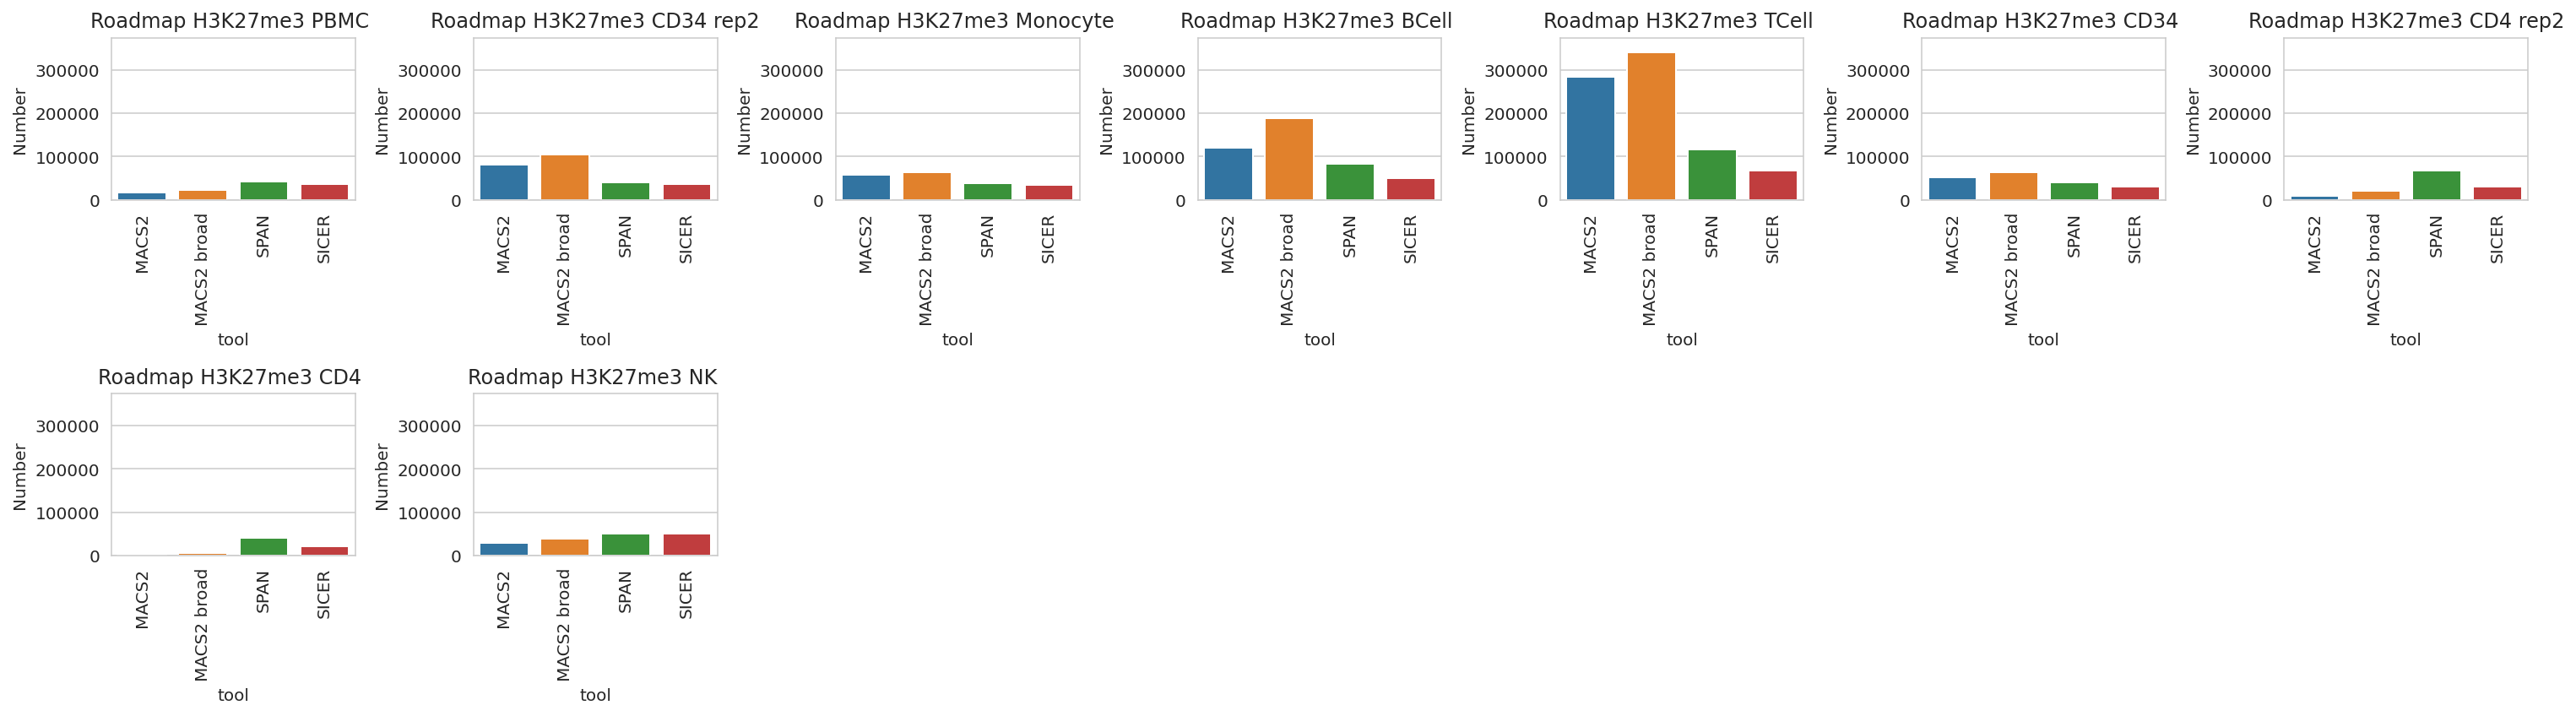

H3K36me3 ENCODE


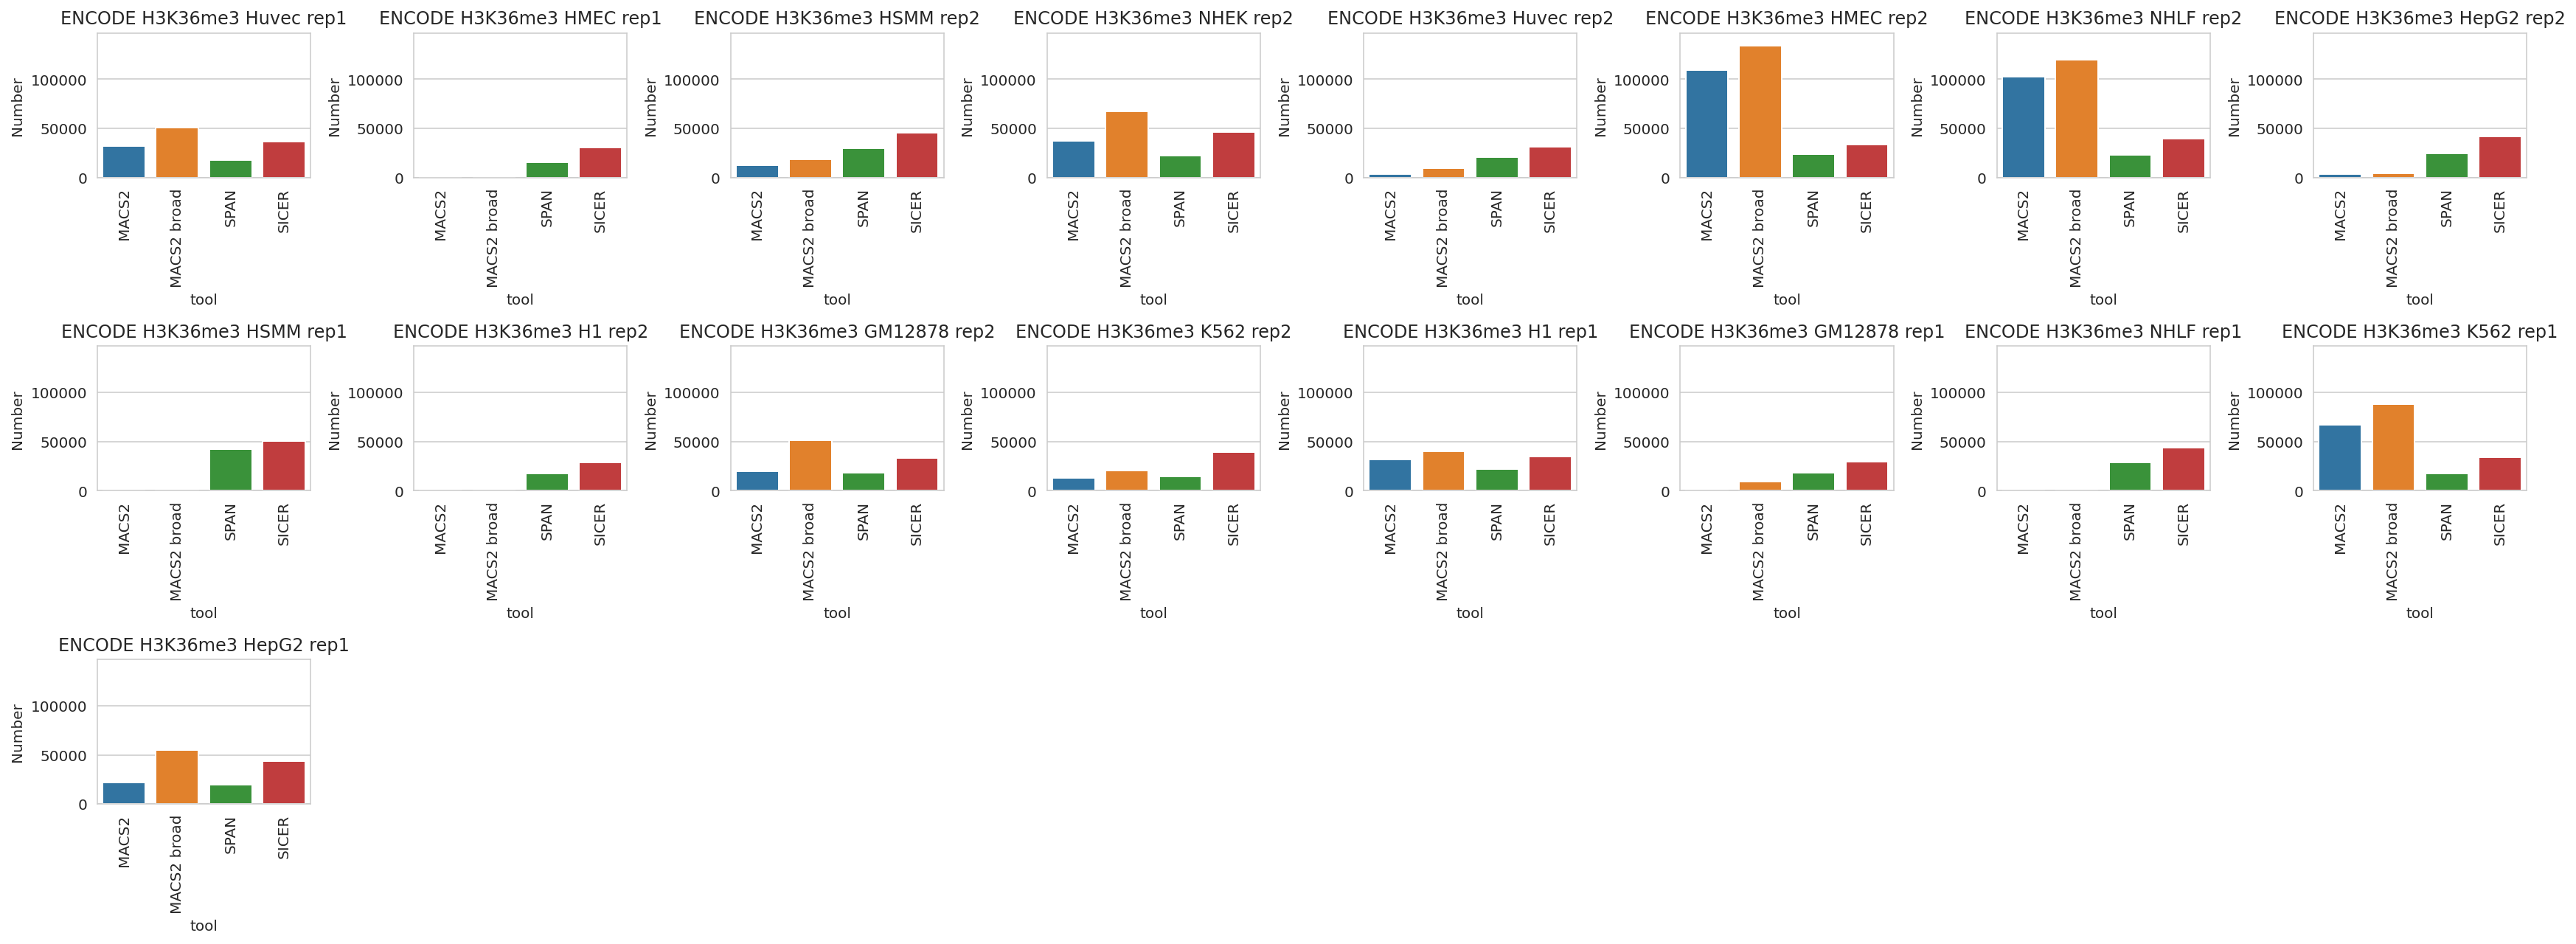

H3K36me3 Roadmap


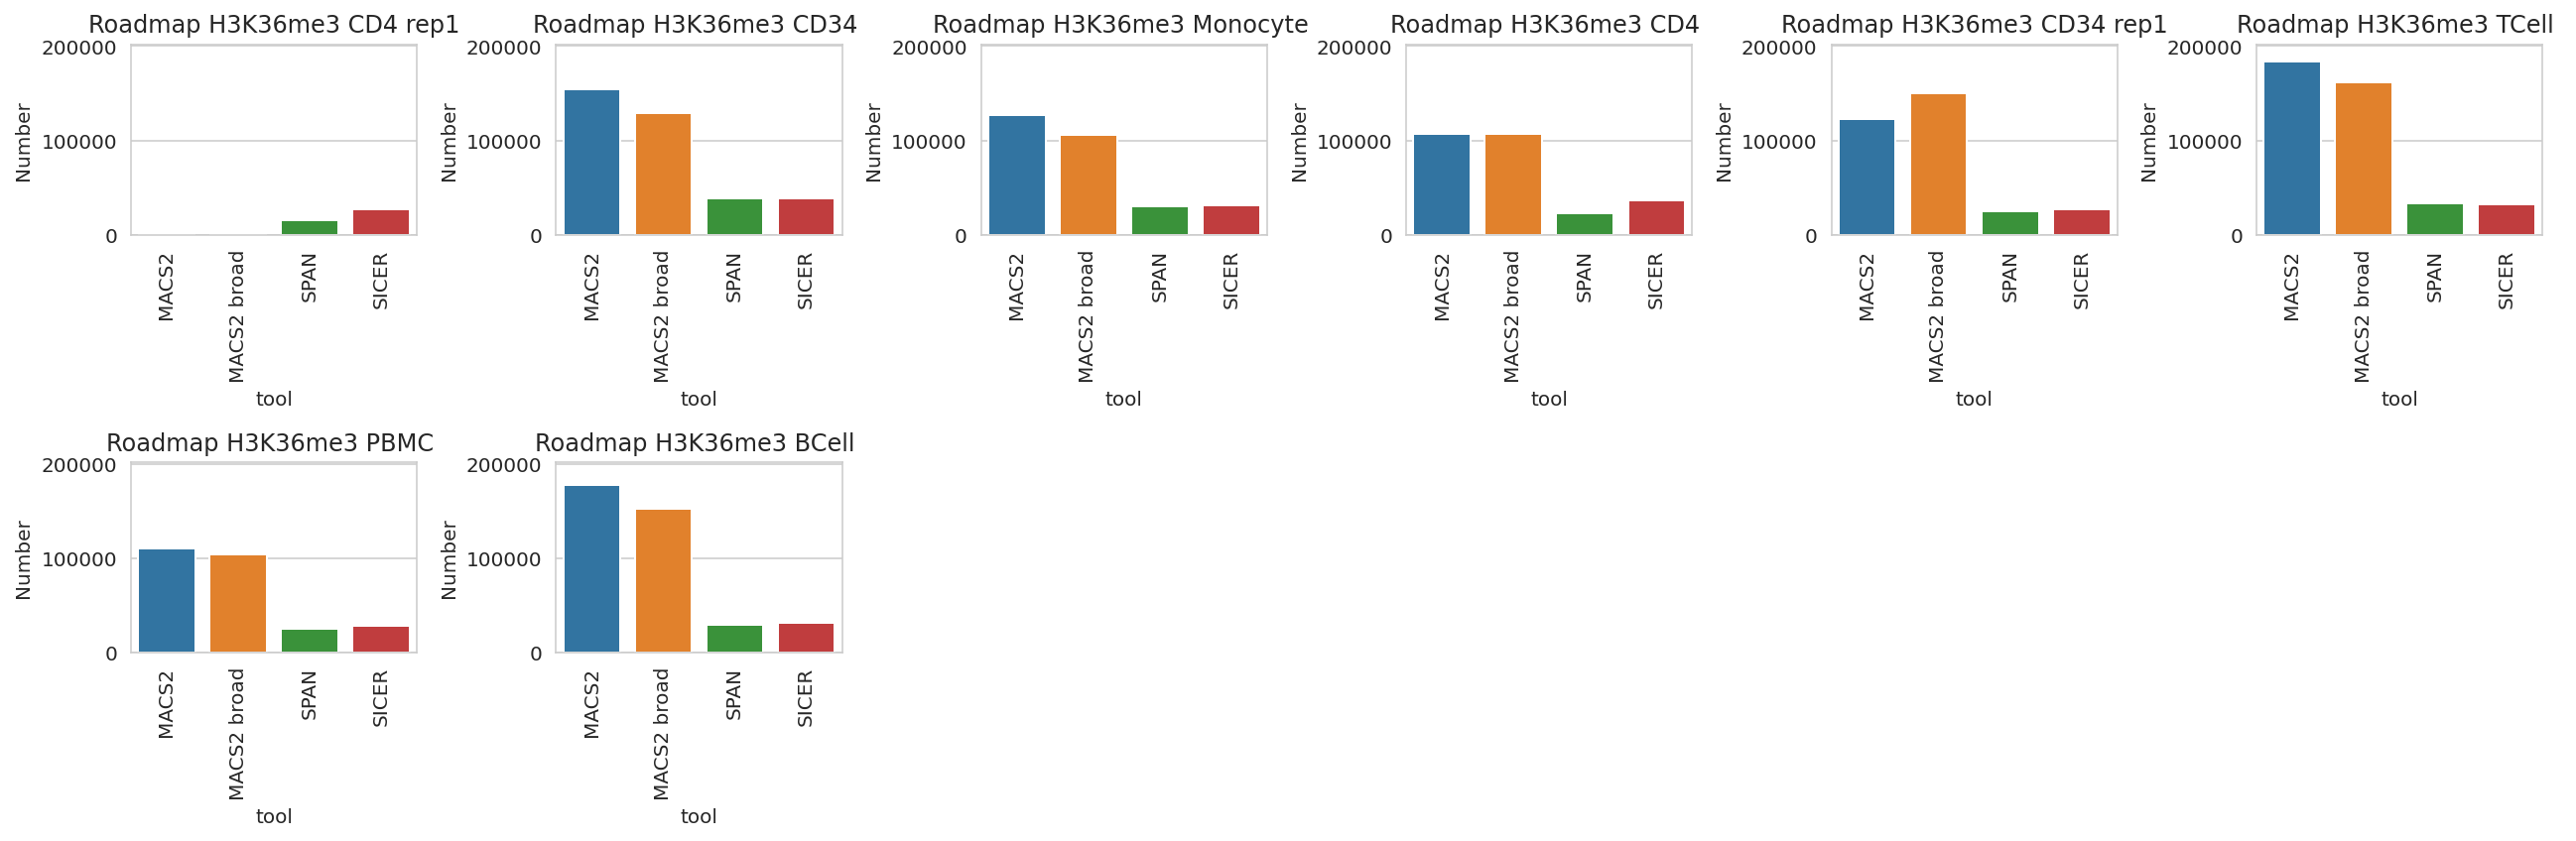

In [12]:
import math
for m, ds in product(MODIFICATIONS, ['ENCODE', 'Roadmap']):
    print(m, ds)
    t = df_peaks[(df_peaks['dataset'] == ds) & (df_peaks['modification'] == m)]
    experiments = [(c, r) for _, (c, r) in t[['cell', 'replicate']].drop_duplicates().iterrows()]
    ncols = int(math.floor(math.sqrt(len(experiments)) + 4))
    nrows = int(math.ceil(len(experiments) / ncols))
    plt.figure(figsize=(3 * ncols, 3 * nrows))
    axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(experiments))]
    for i, (c, r) in enumerate(experiments):
        ax = axs[i]
        ax.title.set_text(f'{ds} {m} {c} {r}')
        g_results = sns.barplot(data=t[(t['cell'] == c) & (t['replicate']==r)],
                            x='tool', y='peaks',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
                            )
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_ylabel('Number')
        ax.set_ylim(0, t['peaks'].max() * 1.1)
    plt.tight_layout()
    plt.show()

In [13]:
# Remove outliers
OUTLIERS = [('H3K4me3', 'NK', ''),
            ('H3K4me1', 'NK', ''),
            ('H3K27me3', 'TCell', '')]
df_peaks = df_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_peaks[['modification', 'cell', 'replicate']].iterrows()]]

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette usin

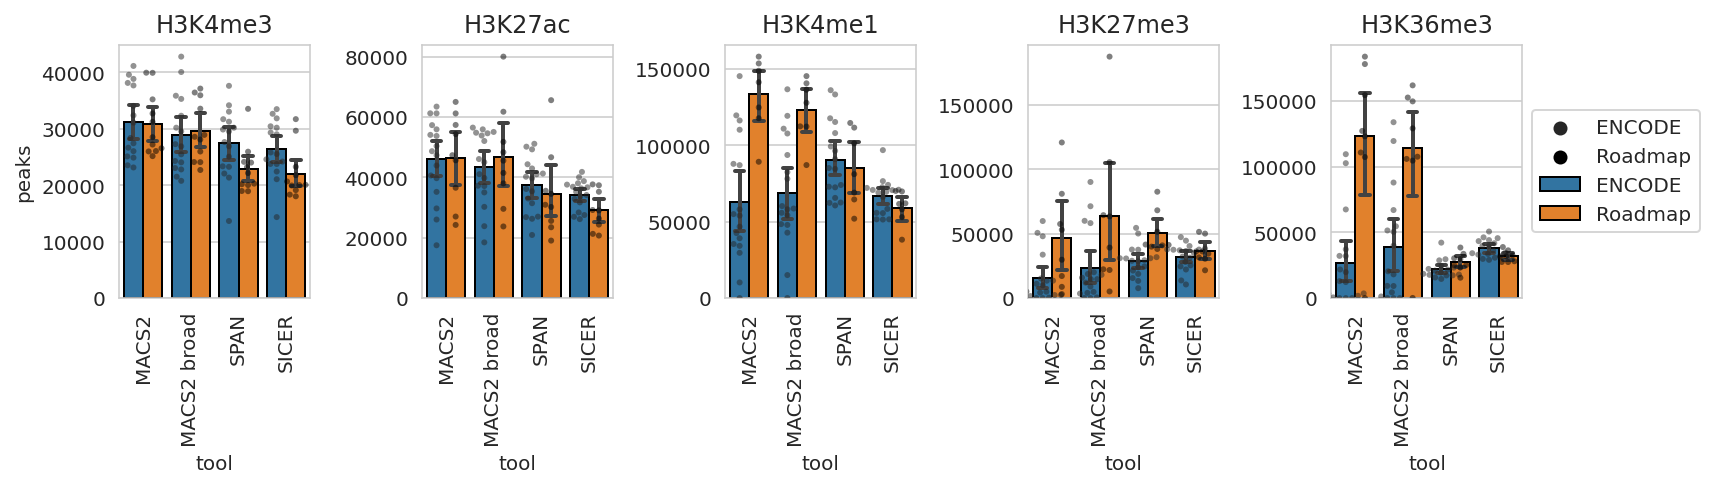

In [14]:
plt.figure(figsize=(12, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
                capsize=.2, errwidth=2, edgecolor="black",
                # palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks',  hue='dataset',
                  dodge=True, size=3, color="black", alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < len(axs) -1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette usin

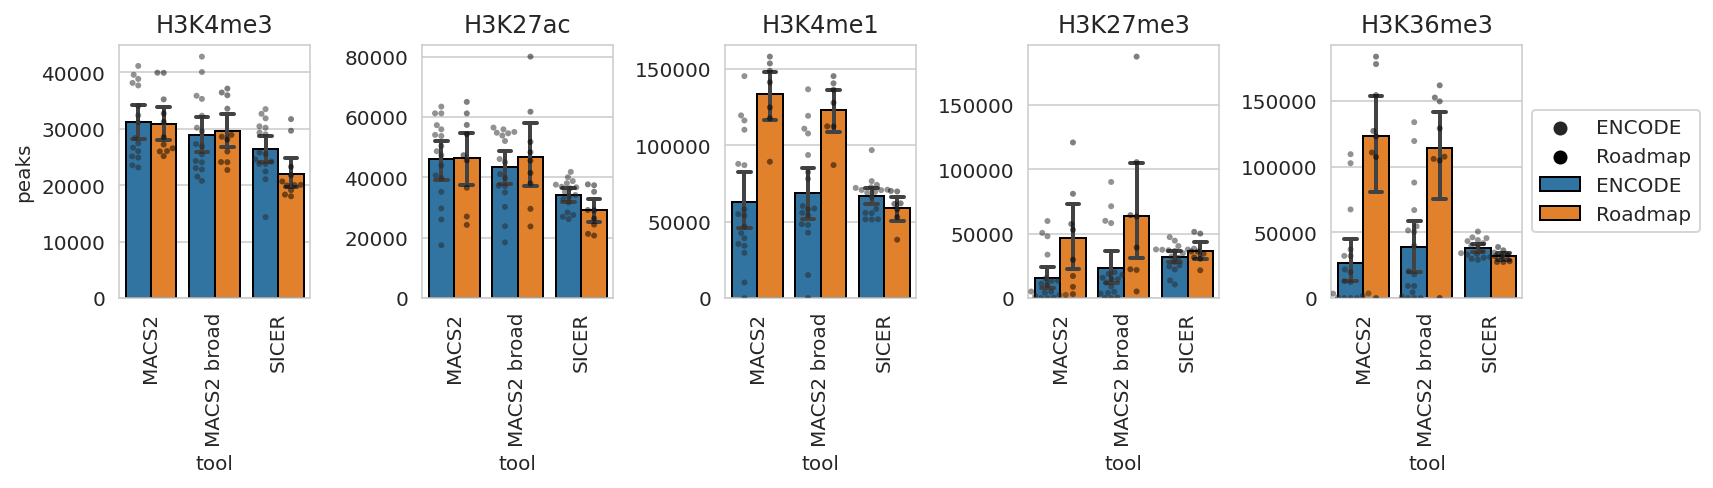

In [15]:
plt.figure(figsize=(12, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
                capsize=.2, errwidth=2, edgecolor="black",
                # palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks',  hue='dataset',
                  dodge=True, size=3, color="black", alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SICER'],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < len(axs) -1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [249]:
df_peaks['ds_c_r'] = df_peaks['dataset'] + ' ' + df_peaks['cell'] + ' ' + df_peaks['replicate']
print('H3K4me1 MACS2 broad ENCODE < 50k peaks')
g1 = df_peaks[(df_peaks['modification'] == 'H3K4me1') & 
              (df_peaks['dataset'] == 'ENCODE') & 
              (df_peaks['tool'] == 'MACS2 broad') & 
              (df_peaks['peaks'] < 50_000)].copy()
display(g1)

print('H3K4me1 MACS2 broad ENCODE > 80k peaks')
g2 = df_peaks[(df_peaks['modification'] == 'H3K4me1') &
              (df_peaks['dataset'] == 'ENCODE') &
              (df_peaks['tool'] == 'MACS2 broad') &
              (df_peaks['peaks'] > 80_000)].copy()

display(g2)

g1_ds_c_r = set(g1['ds_c_r'])
g2_ds_c_r = set(g2['ds_c_r'])

H3K4me1 MACS2 broad ENCODE < 50k peaks


file modification  cell  \
124  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1  HMEC   
129  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1  NHLF   
142  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1  NHLF   
144  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1    H1   
161  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1    H1   

    replicate  peaks         tool dataset            ds_c_r  
124      rep1  15099  MACS2 broad  ENCODE  ENCODE HMEC rep1  
129      rep1  42869  MACS2 broad  ENCODE  ENCODE NHLF rep1  
142      rep2  47946  MACS2 broad  ENCODE  ENCODE NHLF rep2  
144      rep1  48462  MACS2 broad  ENCODE    ENCODE H1 rep1  
161      rep2     62  MACS2 broad  ENCODE    ENCODE H1 rep2

H3K4me1 MACS2 broad ENCODE > 80k peaks


file modification   cell  \
86   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1  Huvec   
93   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1   NHEK   
112  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1   K562   
119  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1   HMEC   
141  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1   NHEK   
167  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1  HepG2   

    replicate   peaks         tool dataset             ds_c_r  
86       rep1   82501  MACS2 broad  ENCODE  ENCODE Huvec rep1  
93       rep1  107843  MACS2 broad  ENCODE   ENCODE NHEK rep1  
112      rep1  119404  MACS2 broad  ENCODE   ENCODE K562 rep1  
119      rep2  136806  MACS2 broad  ENCODE   ENCODE HMEC rep2  
141      rep2  111005  MACS2 broad  ENCODE   ENCODE NHEK rep2  
167      rep1   93762  MACS2 broad  ENCODE  ENCODE HepG2 rep1

# Lengths

In [244]:
print('Load lengths')
ts = []
for dataset, mod, cell, rep, file, tool in tqdm(zip(
        df_peaks['dataset'], df_peaks['modification'], df_peaks['cell'], df_peaks['replicate'], df_peaks['file'],
        df_peaks['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['dataset'] = dataset
    t['modification'] = mod
    t['cell'] = cell
    t['replicate'] = rep
    t['tool'] = tool
    t['footprint'] = sum(lengths)
    t['ds_c_r'] = dataset + ' ' + cell + ' ' + rep
    ts.append(t)
df_lens = pd.concat(ts).reset_index(drop=True)
del ts, t
df_lens.sample(10)

Load lengths


0it [00:00, ?it/s]

length  dataset modification     cell replicate         tool  \
1720301  2199.0   ENCODE      H3K4me1     K562      rep1        SICER   
3624973   426.0  Roadmap      H3K4me1     CD34      rep2  MACS2 broad   
1737834   599.0   ENCODE      H3K27ac       H1      rep1        SICER   
1730068  5199.0   ENCODE     H3K36me3       H1      rep2        SICER   
3824425  1556.0  Roadmap     H3K36me3      CD4            MACS2 broad   
628687    351.0   ENCODE     H3K27me3     K562      rep1        MACS2   
2495623  5926.0   ENCODE     H3K36me3       H1      rep1         SPAN   
4139449  2999.0  Roadmap      H3K4me1     CD34      rep2        SICER   
3019417  6184.0   ENCODE      H3K4me3  GM12878      rep2         SPAN   
4023630  5599.0  Roadmap      H3K27ac      CD4      rep1        SICER   

         footprint               ds_c_r  
1720301  244446561     ENCODE K562 rep1  
3624973  142229505    Roadmap CD34 rep2  
1737834   92199504       ENCODE H1 rep1  
1730068  105359107       ENCODE H1 rep2  
3824425  101133367         Roadmap CD4   
628687     3897646     ENCODE K562 rep1  
2495623  174020347       ENCODE H1 rep1  
4139449  234748088    Roadmap CD34 rep2  
3019417   85506006  ENCODE GM12878 rep2  
4023630   59693688     Roadmap CD4 rep1

In [262]:
# for ds in ['ENCODE', 'Roadmap']:
#     print(ds)
#     plt.figure(figsize=(18, 3))    
#     axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
#     for i, m in enumerate(MODIFICATIONS):
#         ax = axs[i]
#         g_results = sns.histplot(data=df_lens[(df_lens['dataset'] == ds) & (df_lens['modification'] == m)], 
#                                  x='length', hue='tool', ax=ax,
#                                  stat='density', common_bins=False, common_norm=False,
#                                  bins=50, kde=True, log_scale=True, alpha=0.2,
#                                  palette=TOOLS_PALETTE,
#                                  hue_order=TOOLS)
#         g_results.set(xscale='log')
#         g_results.set_ylim(0, 3)
#         g_results.set_xlim(1e2, 7e4)
#         ax.title.set_text(m)
#         if i < len(axs) - 1:
#             ax.legend().set_visible(False)
#         else:
#             sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.tight_layout()
#     plt.show()    
#     

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


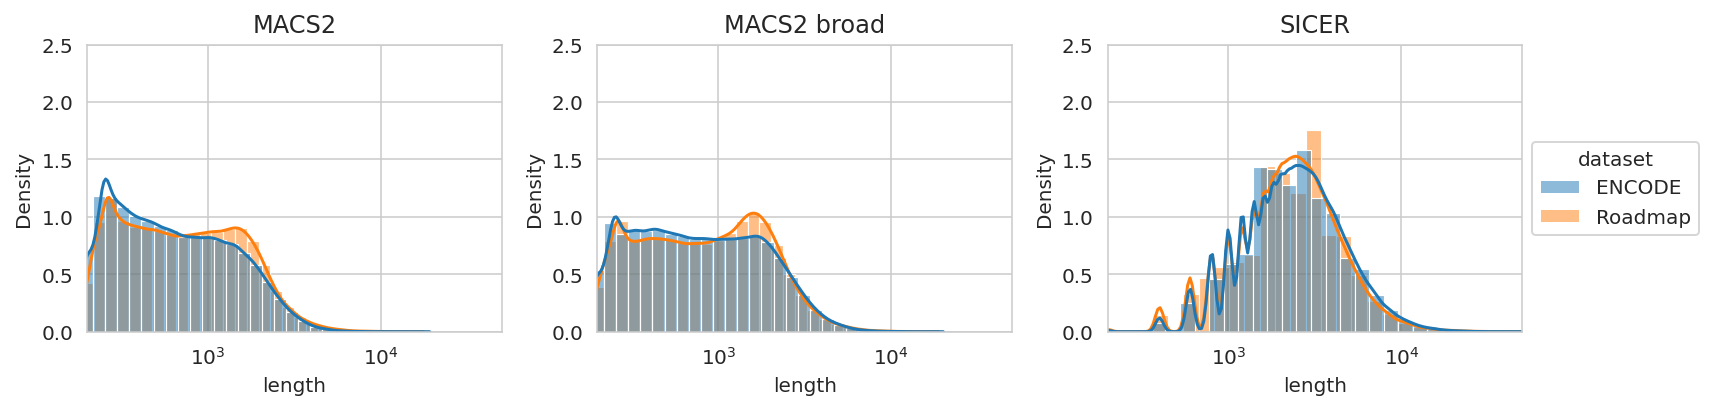

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


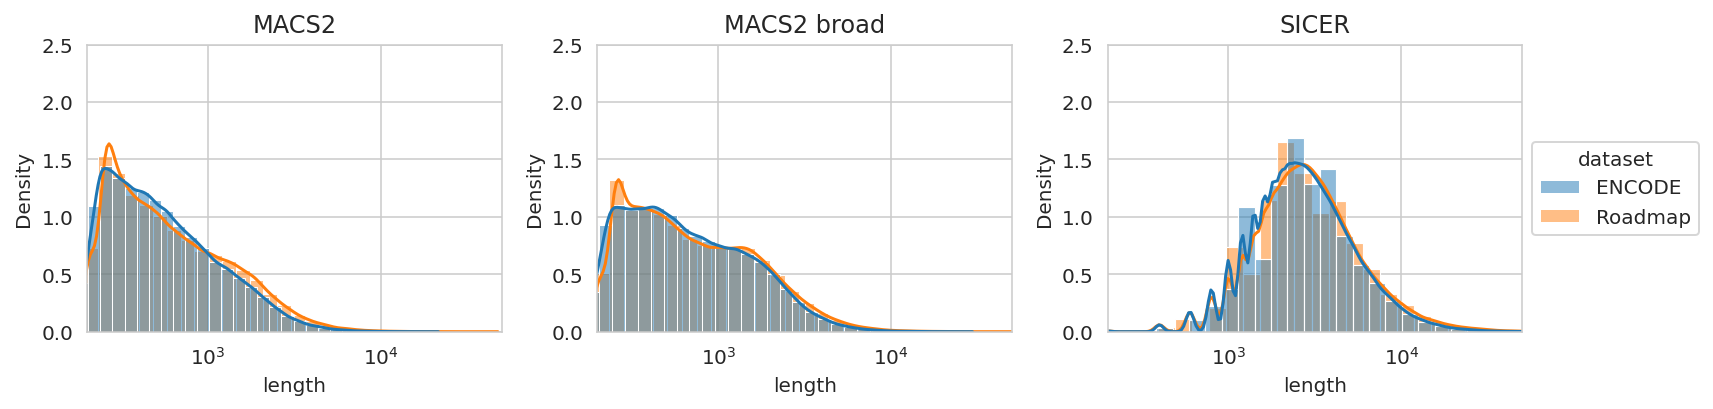

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


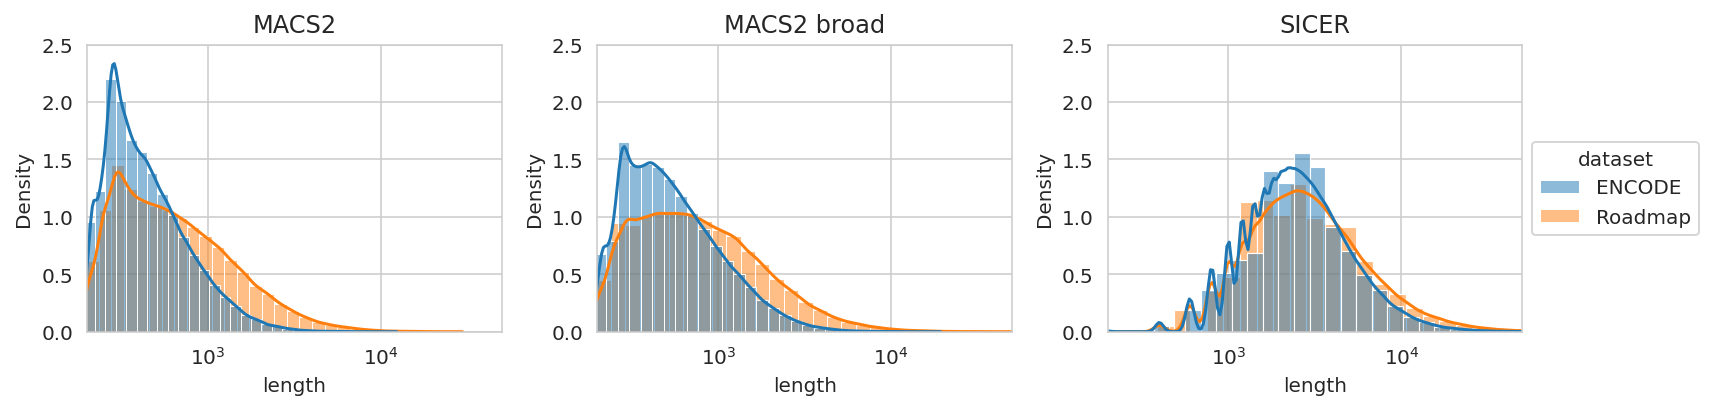

H3K27me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


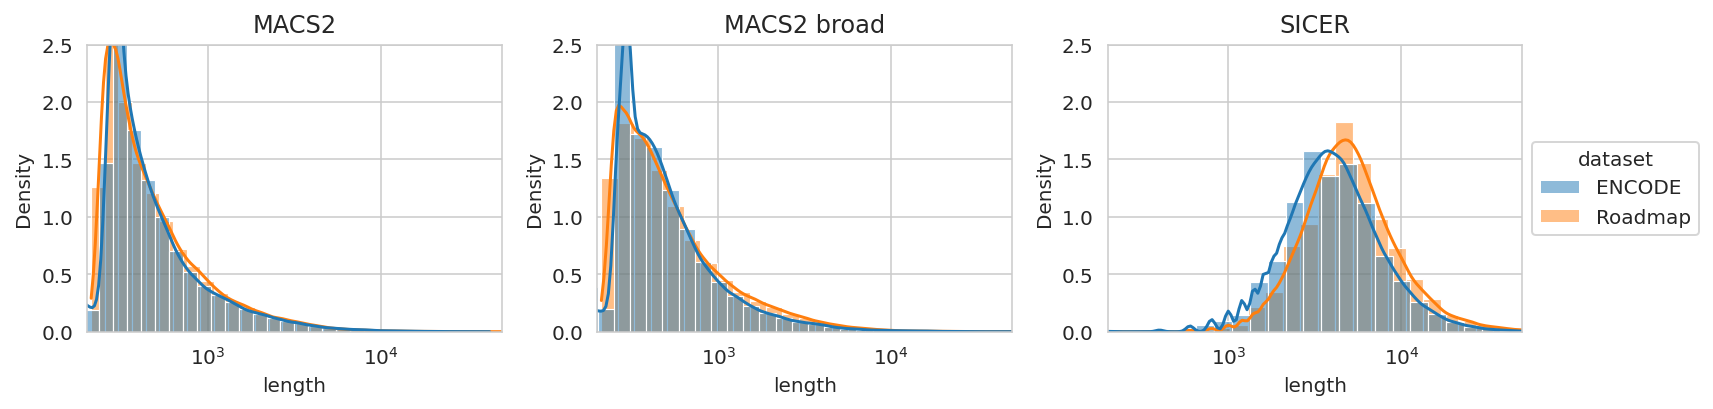

H3K36me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


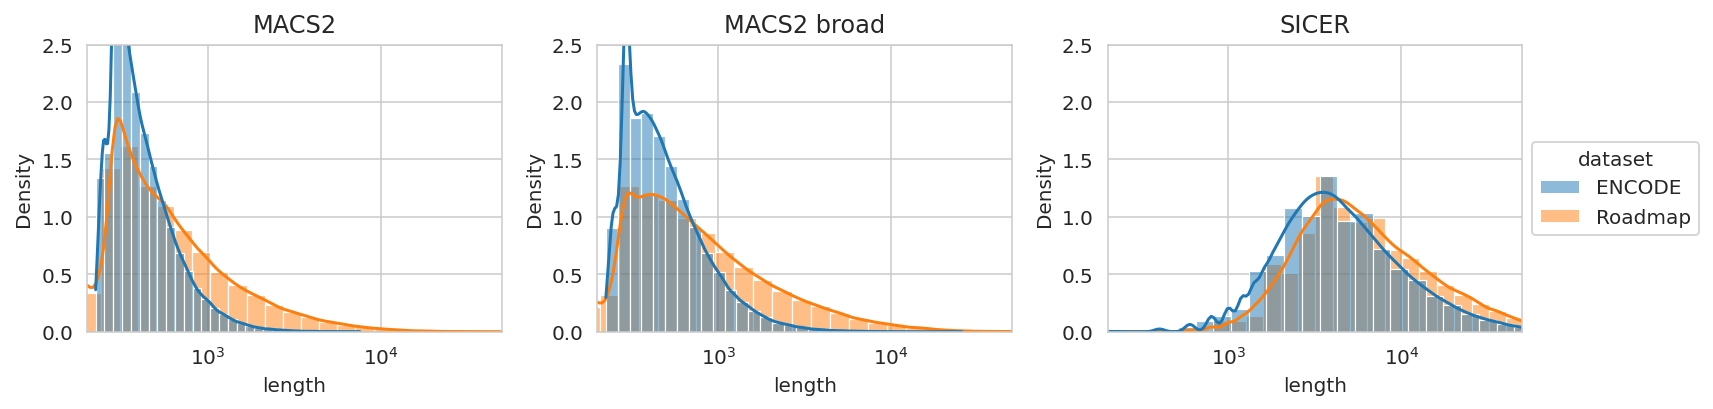

In [18]:
for m in ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']:
    print(m)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=df_lens[(df_lens['modification'] == m) & (df_lens['tool'] == tool)],
                                 x='length', hue='dataset', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 # palette=TOOLS_PALETTE,
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 5e4)
        ax.title.set_text(f'{tool}')
        if i < len(axs) - 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K36me3


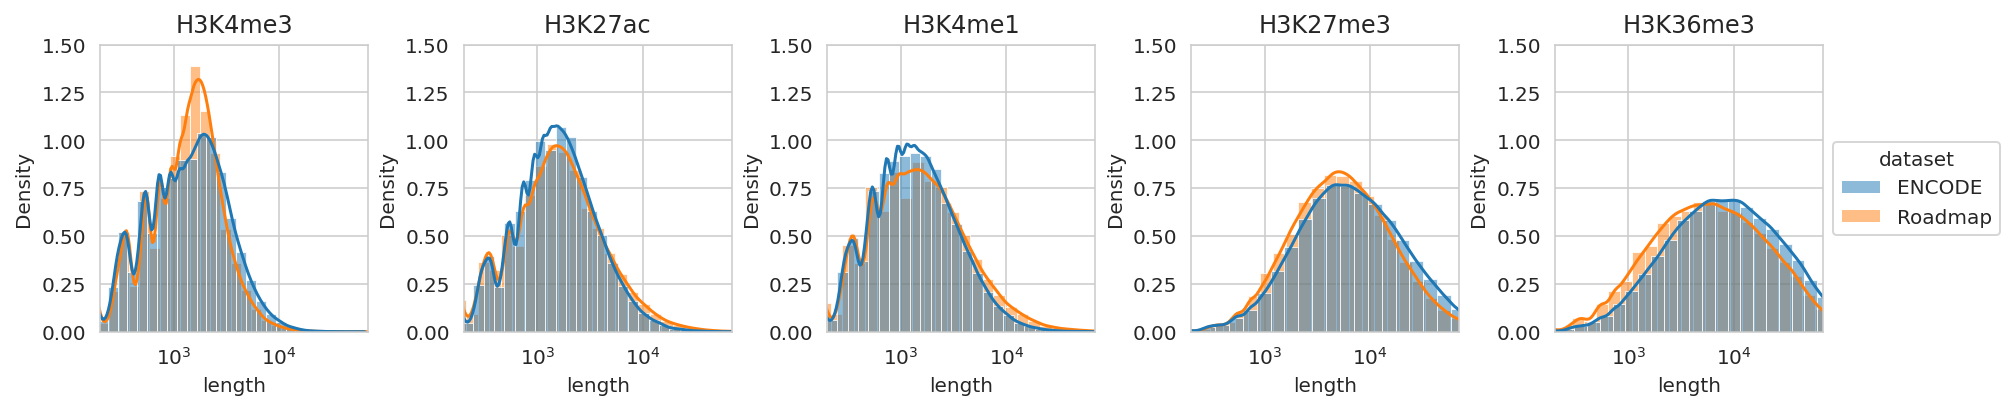

In [19]:
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=df_lens[(df_lens['modification'] == m) & (df_lens['tool'] == 'SPAN')],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             # palette=TOOLS_PALETTE,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 1.5)
    g_results.set_xlim(200, 7e4)
    ax.title.set_text(m)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

In [241]:
# df_lens['cell_rep'] = df_lens['cell'] + ' ' + df_lens['replicate']
# 
# for m in MODIFICATIONS:
#     print(m)
#     plt.figure(figsize=(24, 12))
#     t = list(df_lens[df_lens['modification'] == m].groupby(['dataset', 'cell_rep']))
#     plots = len(t)
#     ncols = int(math.ceil(math.sqrt(plots)))
#     nrows = int(math.ceil(plots / ncols))
#     axs = [plt.subplot(nrows, ncols, i + 1) for i in range(plots)]
# 
#     for i, ((ds, cellrep), dt) in enumerate(t):
#         ax = axs[i]
#         sns.histplot(data=dt,
#                      x='length', hue='tool', 
#                      stat='density', common_bins=False, common_norm=False,
#                      bins=30, kde=True, log_scale=True, alpha=0.5,
#                      palette=TOOLS_PALETTE,
#                      ax=ax)
#         
#         ax.set_title(f'{ds} {cellrep}')
#         ax.set(xscale='log')
#         ax.set_ylim(0, 2.5)
#         ax.set_xlim(200, 7e4)
#         if (i + 1) == plots:
#             sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
#         else:
#             ax.legend().set_visible(False)
#         if i % ncols != 0:
#             ax.set_ylabel(None)
#         if i < ncols:
#             # ax.set_xticks([], minor=False)
#             # ax.set_xticklabels([])
#             ax.set_xlabel(None)
#     plt.tight_layout()
#     plt.show()

## Average length

In [266]:
df_lens_aggr = df_lens[
    ['dataset', 'modification', 'cell', 'replicate', 'tool', 'length', 'footprint']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']).agg('mean').reset_index().drop_duplicates()
df_lens_aggr['ds_c_r'] = df_lens_aggr['dataset'] + ' ' + df_lens_aggr['cell'] + ' ' + df_lens_aggr['replicate']
df_lens_aggr.sample(3)

dataset modification      cell replicate         tool     length  \
463  Roadmap      H3K4me3     BCell            MACS2 broad  1199.2285   
372  Roadmap     H3K27me3     BCell                  SICER  6762.6000   
393  Roadmap     H3K27me3  Monocyte                   SPAN  7784.5323   

       footprint             ds_c_r  
463   28781483.0     Roadmap BCell   
372  343015273.0     Roadmap BCell   
393  297421353.0  Roadmap Monocyte

H3K4me3
H3K27ac


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


H3K4me1


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


H3K27me3


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


H3K36me3


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


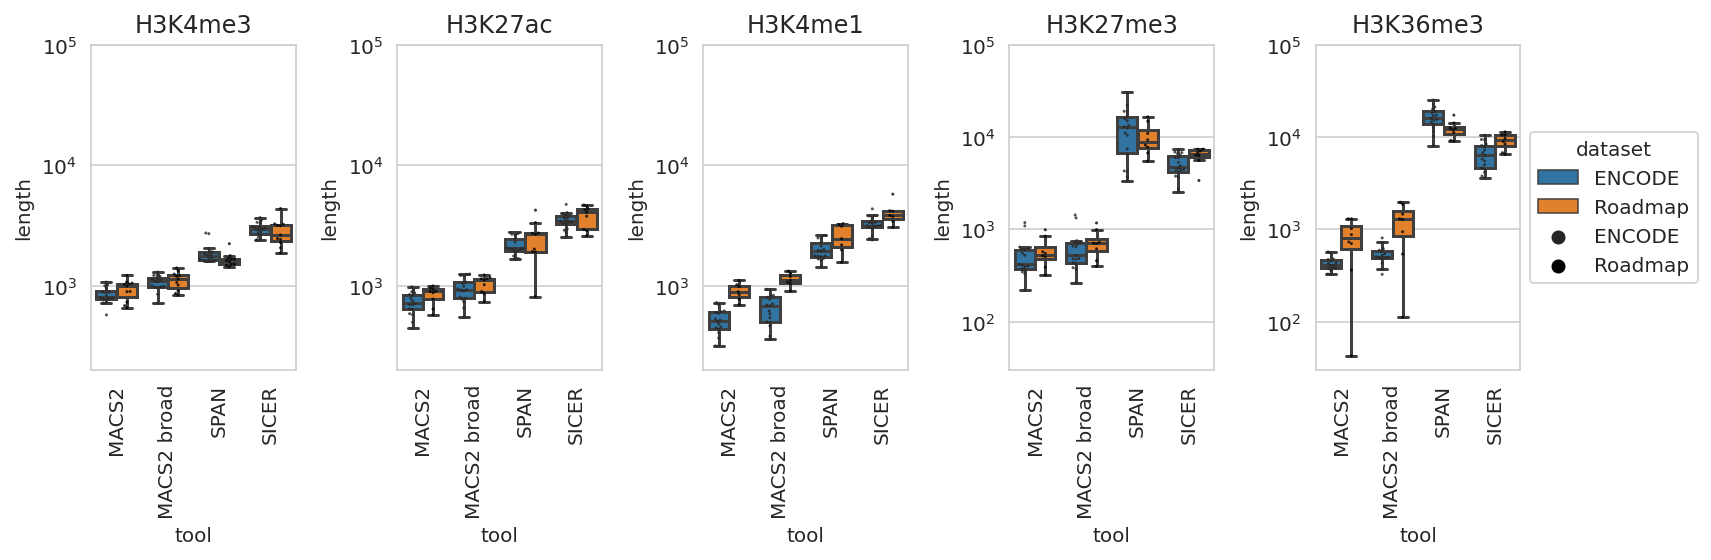

In [281]:
plt.figure(figsize=(12, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    t = df_lens_aggr[df_lens_aggr['modification'] == m].copy()
    sns.boxplot(data=t, x='tool', y='length', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=t, x='tool', y='length', hue='dataset',
                  dodge=True, size=1.5, color='black', alpha=0.8,
                  order=['MACS2', 'MACS2 broad', 'SPAN','SICER'],
                  ax=ax)
    ax.title.set_text(m)
    # ax.set(yscale='log')

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if m not in ['H3K27me3', 'H3K36me3']:
        ax.set_ylim(bottom=200, top=1e5)
    else:
        ax.set_ylim(bottom=30, top=1e5)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K4me3
H3K27ac


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


H3K4me1
H3K27me3


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


H3K36me3


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


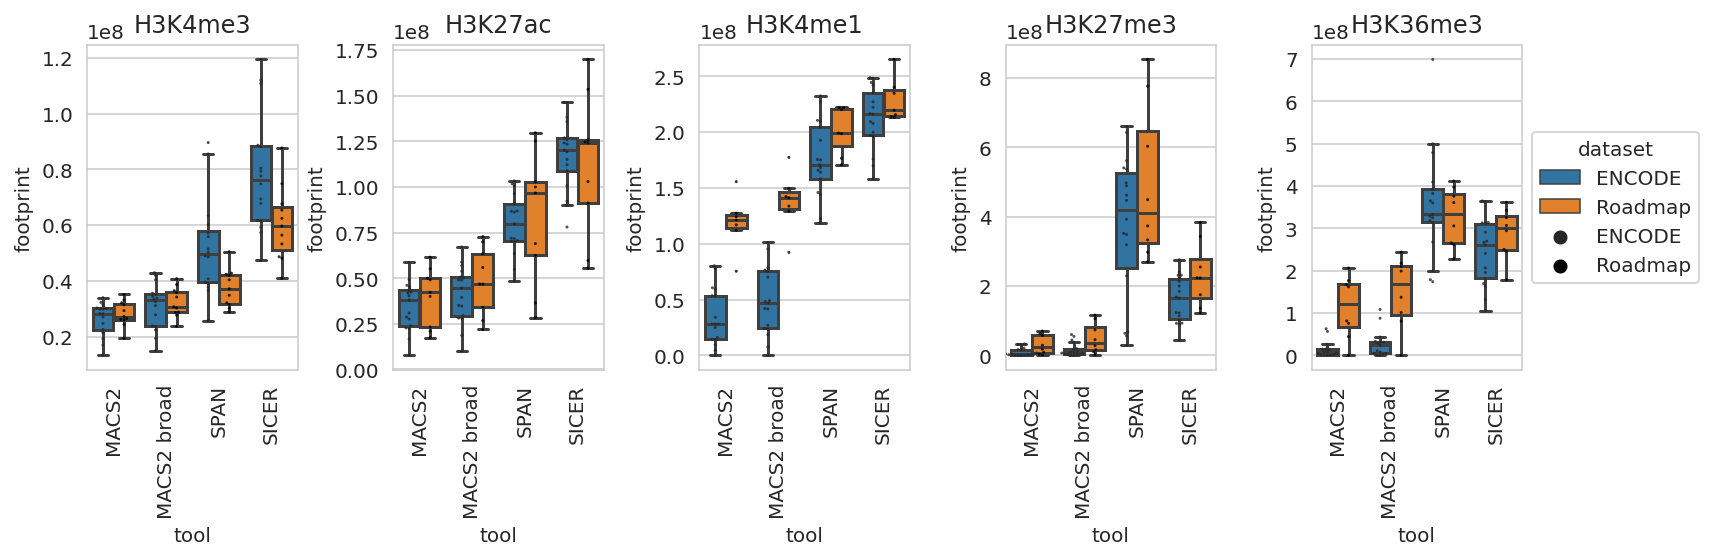

In [257]:
plt.figure(figsize=(12, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_lens_aggr[df_lens_aggr['modification'] == m], x='tool', y='footprint', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_lens_aggr[df_lens_aggr['modification'] == m], x='tool', y='footprint', hue='dataset',
                  dodge=True, size=1.5, color="black", alpha=0.8,
                  order=['MACS2', 'MACS2 broad', 'SPAN','SICER'],
                  ax=ax)
    ax.title.set_text(m)
    # ax.set(yscale='log')

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # if m not in ['H3K27me3', 'H3K36me3']:
    #     ax.set_ylim(1, 4e3)
    # else:
    #     ax.set_ylim(1, 1.7e4)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K4me3
H3K27ac


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


H3K4me1
H3K36me3


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


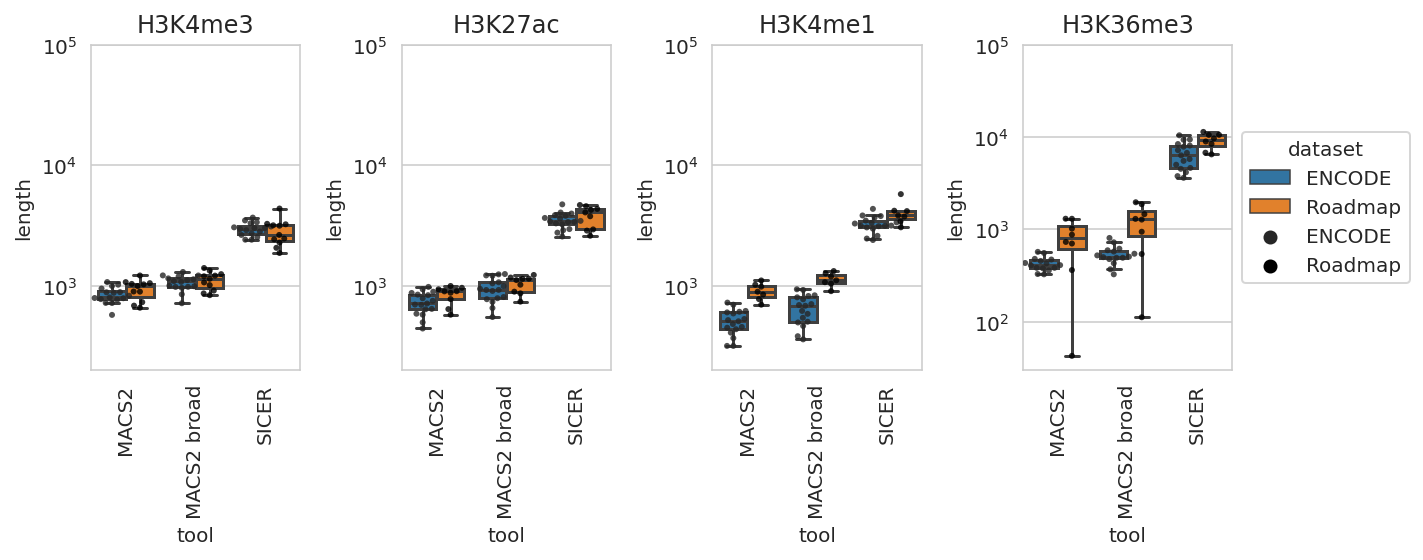

In [282]:
plt.figure(figsize=(10, 4))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_lens_aggr[df_lens_aggr['modification'] == m], x='tool', y='length', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_lens_aggr[df_lens_aggr['modification'] == m], x='tool', y='length', hue='dataset',
                  dodge=True, size=3, 
                  color="black", alpha=0.8,
                  order=['MACS2', 'MACS2 broad', 'SICER'],
                  ax=ax)
    ax.title.set_text(m)
    # ax.set(yscale='log')

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if m not in ['H3K27me3', 'H3K36me3']:
        ax.set_ylim(bottom=200, top=1e5)
    else:
        ax.set_ylim(bottom=30, top=1e5)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

## BAMs

In [24]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        if cell and mod and rep is not None:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams

In [25]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, 'Control')
df_immune_bams['dataset'] = 'Roadmap'

df_bams = pd.concat([df_encode_bams, df_immune_bams]).reset_index(drop=True)

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

In [26]:
df_bams

bam_file modification      cell  \
0    /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3      NHLF   
1    /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K36me3      NHEK   
2    /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K27ac      NHEK   
3    /home/jetbrains/data/2023_GSE26320/bams/GSM646...     H3K27me3      HSMM   
4    /home/jetbrains/data/2023_GSE26320/bams/GSM646...      H3K4me1      K562   
..                                                 ...          ...       ...   
154  /home/jetbrains/data/2023_Immune/bams/BCell_H3...      H3K4me3     BCell   
155  /home/jetbrains/data/2023_Immune/bams/Monocyte...      H3K27ac  Monocyte   
156  /home/jetbrains/data/2023_Immune/bams/CD34_H3K...     H3K36me3      CD34   
157  /home/jetbrains/data/2023_Immune/bams/CD4_H3K4...      H3K4me1       CD4   
158  /home/jetbrains/data/2023_Immune/bams/PBMC_H3K...     H3K27me3      PBMC   

    replicate     reads  dataset  
0        rep1  14385159   ENCODE  
1        rep2   7569713   ENCODE  
2        rep1   9377615   ENCODE  
3        rep2   8356060   ENCODE  
4        rep2   7777248   ENCODE  
..        ...       ...      ...  
154            24648172  Roadmap  
155            20750359  Roadmap  
156            20291379  Roadmap  
157      rep1  18117773  Roadmap  
158            20417465  Roadmap  

[159 rows x 6 columns]

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


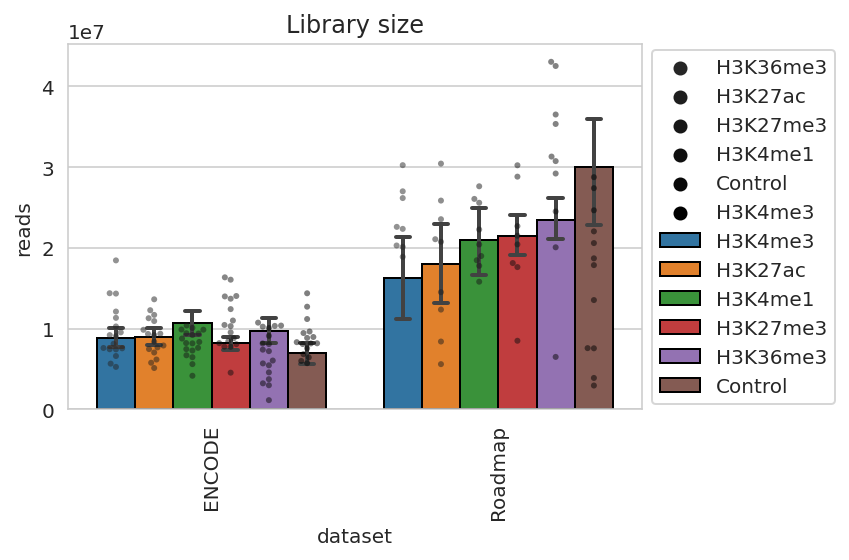

In [27]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
sns.barplot(data=df_bams, hue='modification', x='dataset', y='reads',
            capsize=.05, errwidth=2, edgecolor="black",
            hue_order=MODIFICATIONS+['Control'],
            ax=ax)
sns.swarmplot(data=df_bams, hue='modification', x='dataset', y='reads',
              dodge=True, size=3, color="black", alpha=0.5,
              ax=ax)
ax.set_title('Library size')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [100]:
df_aggr = pd.merge(df_peaks[['dataset', 'modification', 'cell', 'replicate', 'tool', 'peaks']], 
             df_bams[['dataset', 'modification', 'cell', 'replicate', 'reads']], 
             on=['dataset', 'modification', 'cell', 'replicate'], how='inner')
df_aggr = pd.merge(df_aggr, 
             df_lens_aggr[['dataset', 'modification', 'cell', 'replicate', 'tool', 'length', 'footprint']], 
             on=['dataset', 'modification', 'cell', 'replicate', 'tool'], how='inner')
df_aggr.sample(3)

dataset modification      cell replicate         tool   peaks     reads  \
227   ENCODE     H3K27me3        H1      rep1  MACS2 broad   14675   5612270   
402  Roadmap     H3K36me3  Monocyte                  MACS2  127115  20118416   
303   ENCODE     H3K27me3      NHLF      rep1  MACS2 broad     513   7296594   

          length    footprint  
227  1292.439600   19070862.0  
402  1312.654900  167040107.0  
303   473.516569     242914.0



peaks vs length


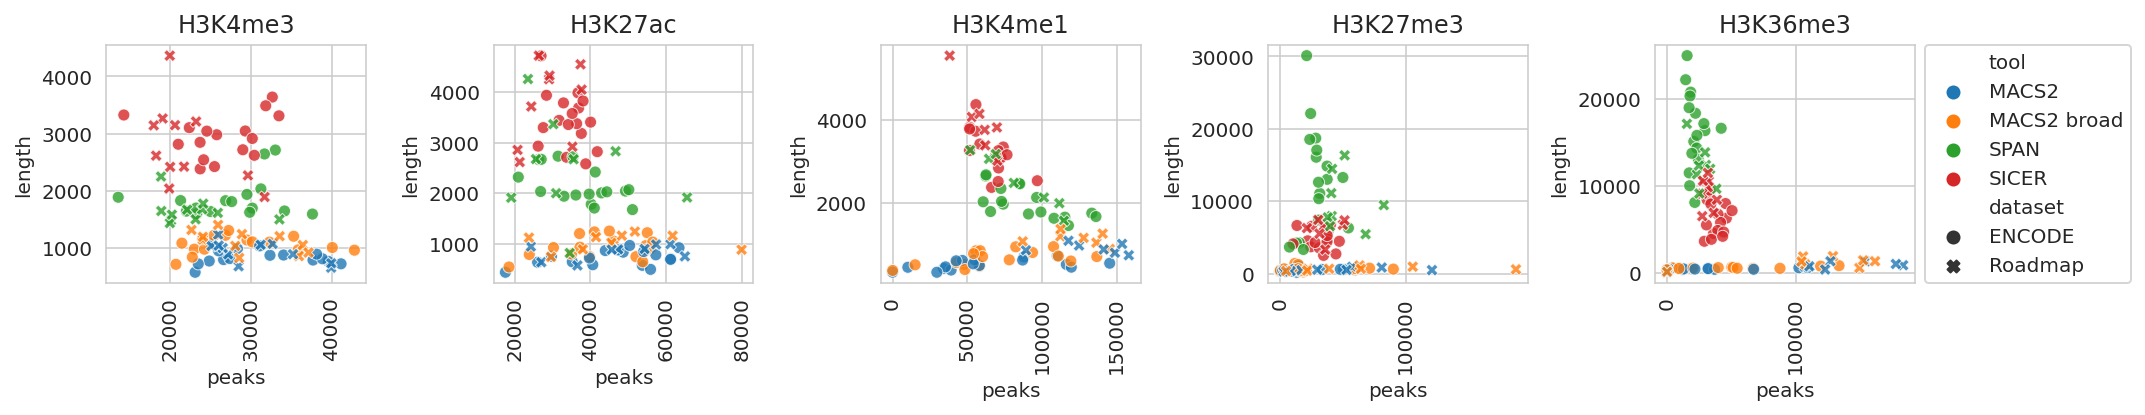



peaks vs reads


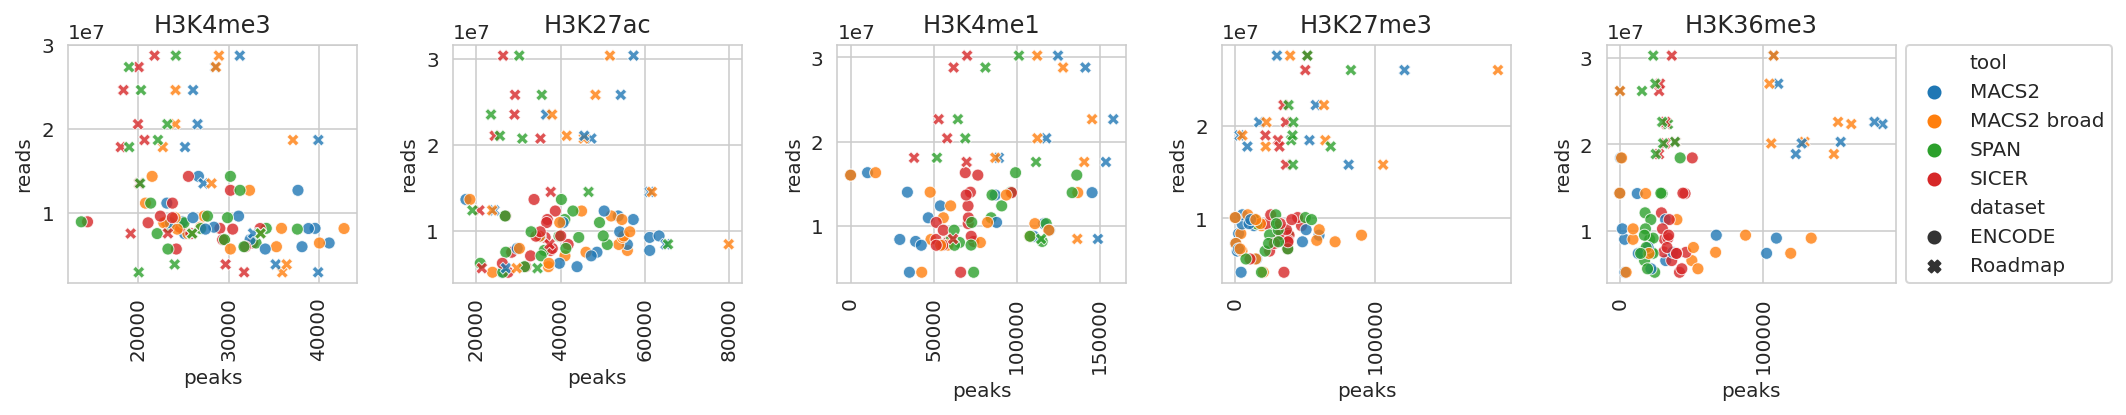



length vs reads


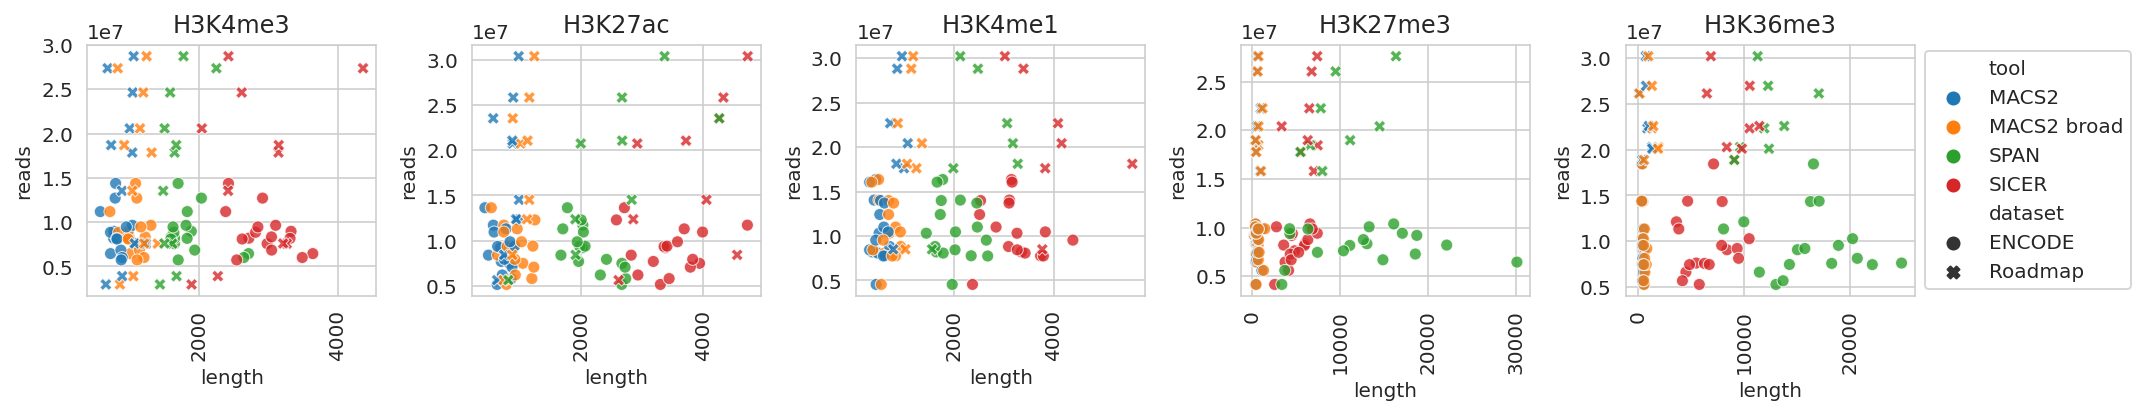



peaks vs footprint


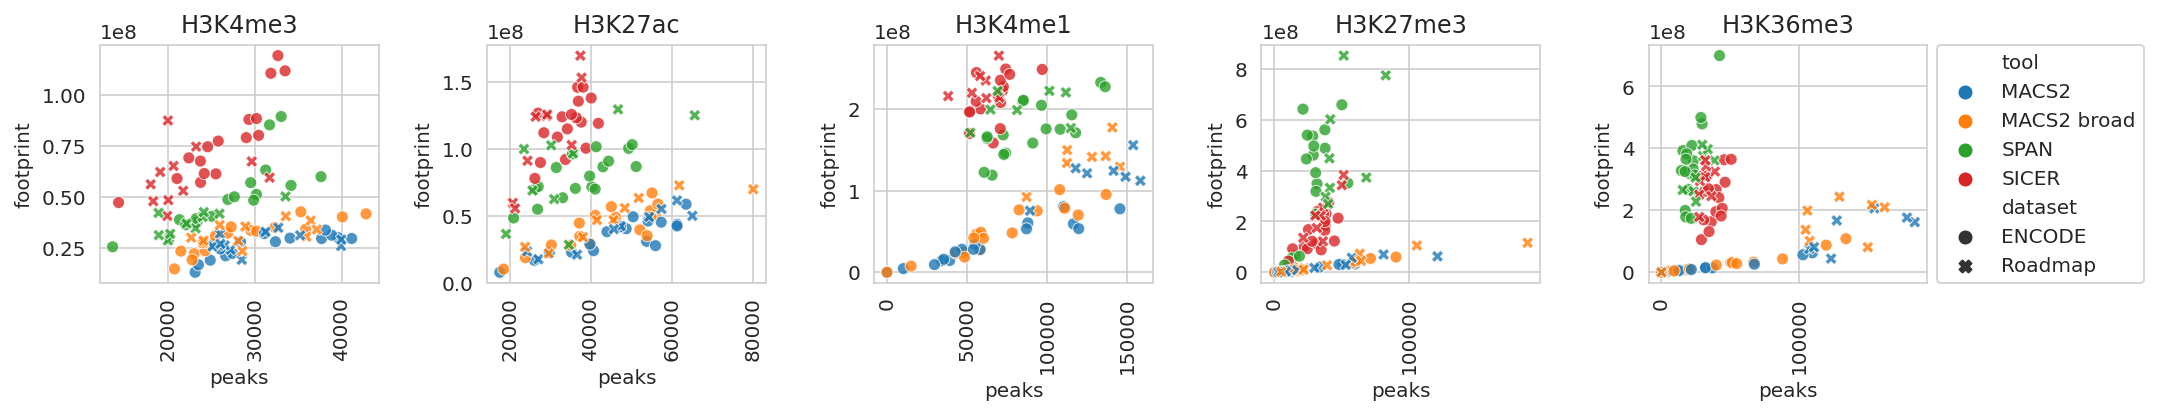



reads vs footprint


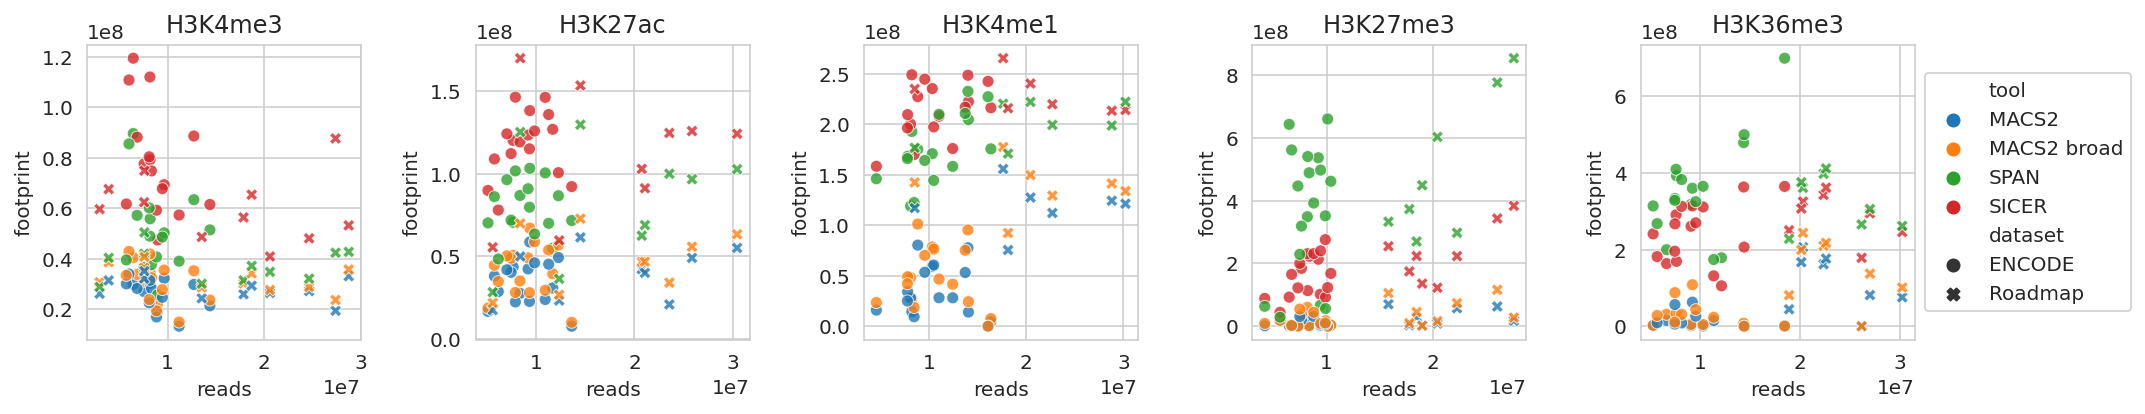

In [101]:
for x, y in [('peaks', 'length'), ('peaks', 'reads'), ('length', 'reads'), ('peaks', 'footprint'), ('reads', 'footprint')]:
    print(f'\n\n{x} vs {y}')
    plt.figure(figsize=(15, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
        ax = axs[i]
        sns.scatterplot(
            df_aggr[df_aggr['modification'] == m], x=x, y=y, hue='tool', 
            alpha=0.8,
            style='dataset',
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            ax = ax)
        ax.title.set_text(m)
        if i < len(axs) - 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        if x != 'reads':
            ax.xaxis.set_tick_params(rotation=90)
    plt.tight_layout()
    plt.show()



peaks vs length


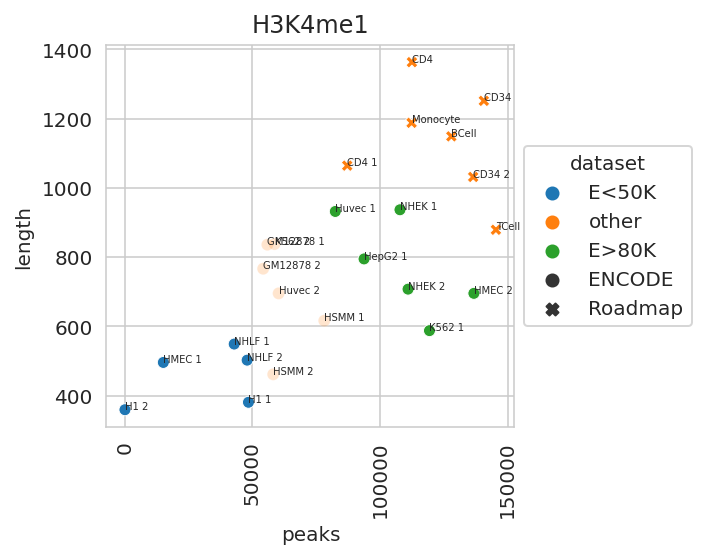



peaks vs reads


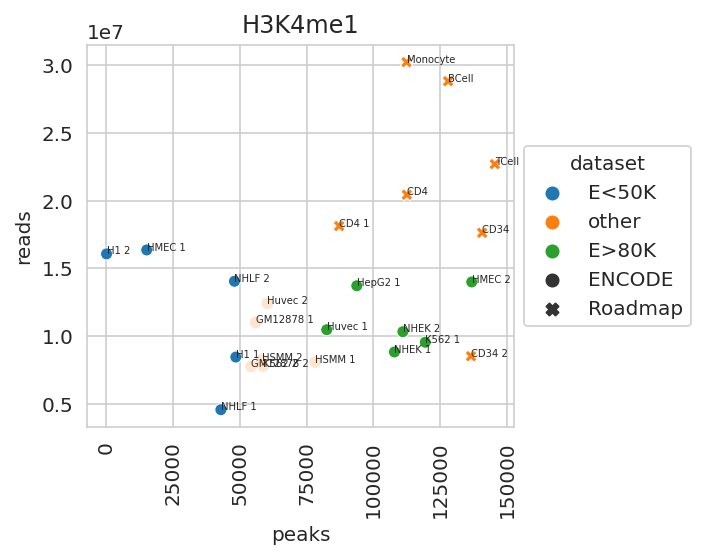



length vs reads


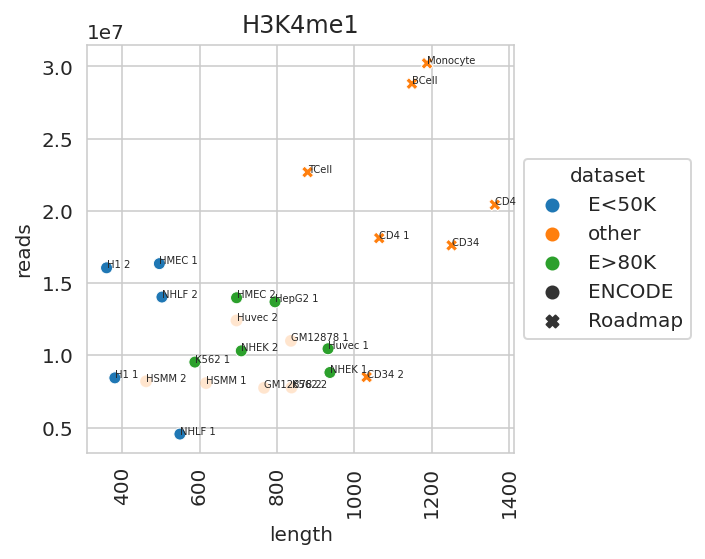



peaks vs footprint


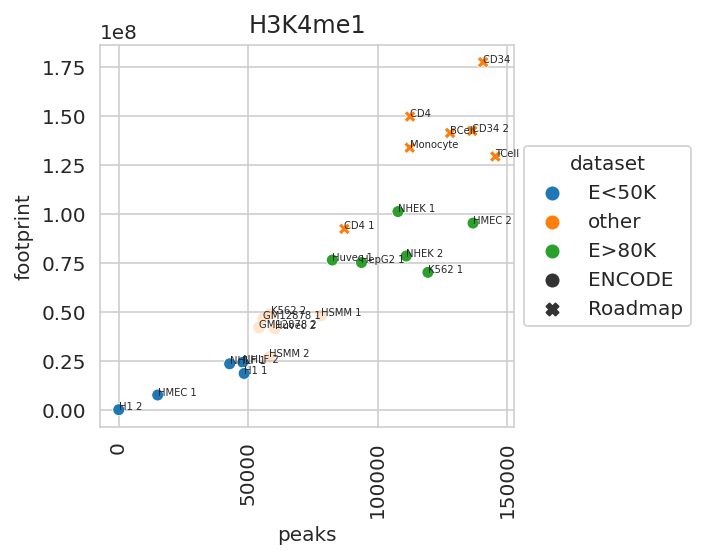



reads vs footprint


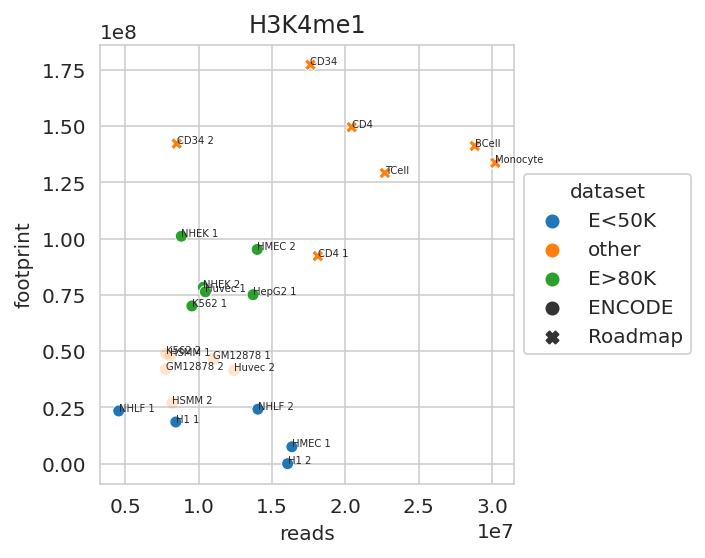

In [260]:
for x, y in [('peaks', 'length'), ('peaks', 'reads'), ('length', 'reads'), ('peaks', 'footprint'), ('reads', 'footprint')]:
    print(f'\n\n{x} vs {y}')
    plt.figure(figsize=(5, 4))
    ax = plt.axes()
    tt = df_aggr[(df_aggr['modification'] == 'H3K4me1') & (df_aggr['tool'] == 'MACS2 broad')].copy()
    tt['ds_c_r'] = tt['dataset'] + ' ' + tt['cell'] + ' ' + tt['replicate']
    sns.scatterplot(
        tt, x=x, y=y, 
        style='dataset',
        hue=['E<50K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else 'other' for dscr in tt['ds_c_r']],
        alpha=[1 if dscr in g1_ds_c_r or dscr in g2_ds_c_r or 'Roadmap' in dscr else 0.2 for dscr in tt['ds_c_r']],
        ax = ax)
    for xv, yv, cell, rep in zip(tt[x], tt[y], tt['cell'], tt['replicate']):
        rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
        ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
    ax.title.set_text('H3K4me1')
    sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if x != 'reads':
        ax.xaxis.set_tick_params(rotation=90)
    plt.tight_layout()
    plt.show()

## Coverage

In [232]:
print('Load roughness from wiggle.ipynb')
df_roughness = pd.read_csv('/home/jetbrains/data/2023_wiggle/roughness_10000bp_50000_100_1000_2024-02-08T18:10.csv.gz')
df_roughness = df_roughness[df_roughness['type'].isin(['ENCODE', 'Roadmap'])]
df_roughness.rename({'type': 'dataset'}, axis=1, inplace=True)
df_roughness.loc[~df_roughness['replicate'].isin(['rep1', 'rep2']), 'replicate'] = ''
df_roughness['std_mean'] = df_roughness['rq'] / df_roughness['mean'] 
df_roughness.sample(3)

Load roughness from wiggle.ipynb


modification     cell replicate  dataset                  position  \
140479      H3K27ac    TCell            Roadmap  chr2:101940000-101950000   
128880      H3K27ac  GM12878      rep2   ENCODE  chr3:121300000-121310000   
106802      H3K4me1     NHLF      rep1   ENCODE    chr3:65300000-65310000   

        mean     ra         rq  std_mean  
140479  60.0  64.00  76.157731  1.269296  
128880   5.0   9.40  21.794495  4.358899  
106802   7.0  12.74  25.514702  3.644957

In [233]:
print('Assign groups by coverage percentiles individually in each track')
BIN = 10_000
ts = []
for (ds, m, c, r), group in df_roughness.groupby(['dataset', 'modification', 'cell', 'replicate']):
    group = group.sort_values(by=['mean'], ascending=False)
    group['percentile'] = [10 * int(10.0 * i / len(group)) for i in range(len(group))]
    total_coverage = df_bams[(df_bams['dataset'] == ds) & 
                             (df_bams['modification'] == m) & 
                             (df_bams['cell'] == c) & 
                             (df_bams['replicate'] == r)]['reads'].values[0]
    group['rpkm'] = group['mean'] / ((total_coverage / 1.e6) * (BIN / 1e3))
    ts.append(group)
df_roughness_perc = pd.concat(ts).reset_index(drop=True)
del ts
df_roughness_perc.sample(5)

Assign groups by coverage percentiles individually in each track


modification     cell replicate dataset                  position  mean  \
30197      H3K4me1     NHEK      rep1  ENCODE  chr3:166080000-166090000  56.0   
15378      H3K27ac     NHLF      rep1  ENCODE  chr3:170980000-170990000  18.5   
4988       H3K27ac     HMEC      rep2  ENCODE    chr3:95500000-95510000   7.0   
607        H3K27ac  GM12878      rep1  ENCODE  chr1:117690000-117700000   9.0   
20159      H3K4me1       H1      rep2  ENCODE  chr3:194070000-194080000  84.0   

          ra          rq  std_mean  percentile      rpkm  
30197  70.24  108.692226  1.940933          10  0.635099  
15378  27.38   34.391133  1.858980          30  0.233718  
4988   12.60   23.473389  3.353341          90  0.070989  
607    15.84   25.865034  2.873893          60  0.127677  
20159  77.48  102.927159  1.225323          10  0.522979

In [234]:
print('Compute Signal-to-noise ratio')
t = df_roughness_perc[
    ['dataset', 'modification', 'cell', 'replicate', 'percentile', 'mean']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'percentile']).agg('mean').reset_index()
ts = []
for (ds, m, c, r), dt in t.groupby(['dataset', 'modification', 'cell', 'replicate']):
    snr = dt[dt['percentile'] <= 20]['mean'].mean() / dt[dt['percentile'] >= 80]['mean'].mean()
    ts.append((ds, m, c, r, snr))
df_snr = pd.DataFrame(ts, columns=['dataset', 'modification', 'cell', 'replicate', 'signal-to-noise'])
df_snr.sample(3)

Compute Signal-to-noise ratio


dataset modification  cell replicate  signal-to-noise
38  Roadmap      H3K27ac   CD4      rep1         2.947909
28   ENCODE      H3K4me1  K562      rep1        17.585674
47  Roadmap      H3K4me1   CD4      rep1         4.112862

Signal-to-noise


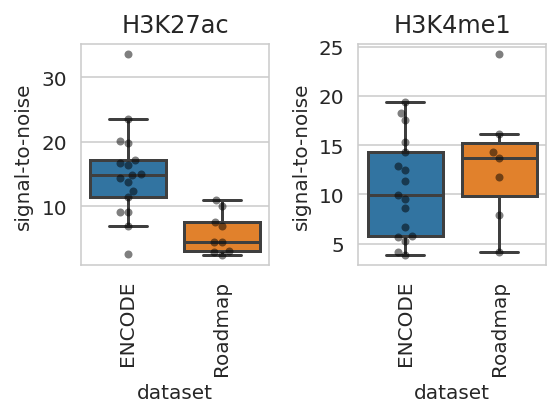

In [235]:
print('Signal-to-noise')
plt.figure(figsize=(4, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    sns.boxplot(data=df_snr[(df_snr['modification'] == m)], x='dataset', y='signal-to-noise',
                showfliers=False,
                ax=ax)
    sns.swarmplot(data=df_snr[(df_snr['modification'] == m)], x='dataset', y='signal-to-noise',
                  dodge=True, size=4, color="black", alpha=0.5,
                  ax=ax)

    ax.title.set_text(m)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [236]:
print('Pick only top covered regions, where most of the peaks are located for average')
df_roughness_perc_aggr = df_roughness_perc[df_roughness_perc['percentile'] <= 100][
    ['dataset', 'modification', 'cell', 'replicate', 'mean', 'rpkm', 'std_mean']
].groupby(['dataset', 'modification', 'cell', 'replicate']).agg('mean').reset_index()
df_roughness_perc_aggr.sample(3)

Pick only top covered regions, where most of the peaks are located for average


dataset modification   cell replicate     mean      rpkm  std_mean
25   ENCODE      H3K4me1  HepG2      rep1  47.1975  0.344321  1.882621
26   ENCODE      H3K4me1  Huvec      rep1  44.9885  0.430091  2.080016
47  Roadmap      H3K4me1    CD4      rep1  66.2455  0.365638  1.316616

mean


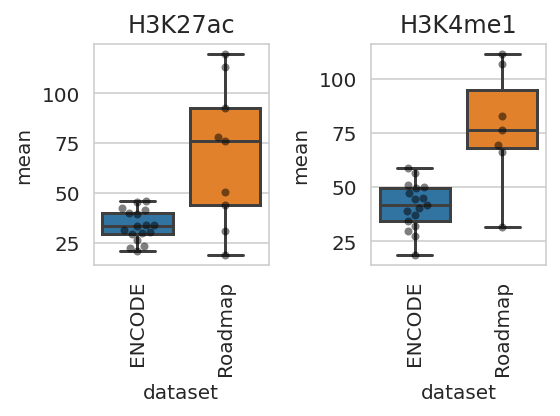

rpkm


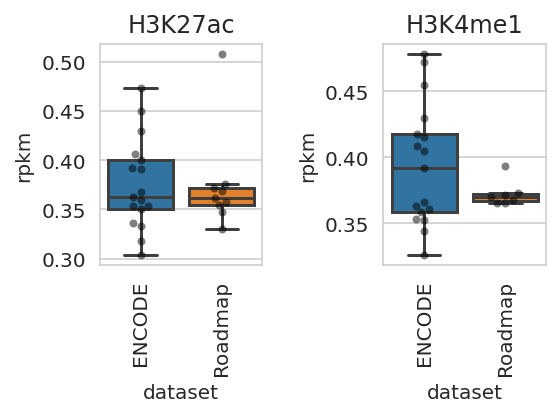

std_mean


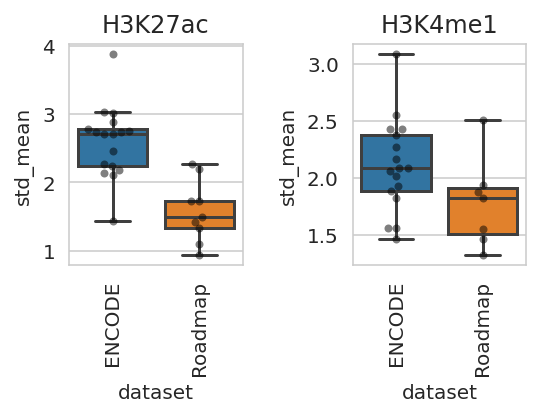

In [237]:
for y in ['mean', 'rpkm', 'std_mean']:
    print(y)
    plt.figure(figsize=(4, 3))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        ax = axs[i]
        sns.boxplot(data=df_roughness_perc_aggr[(df_roughness_perc_aggr['modification'] == m)], x='dataset', y=y,
                    showfliers=False,
                    ax=ax)
        sns.swarmplot(data=df_roughness_perc_aggr[(df_roughness_perc_aggr['modification'] == m)], x='dataset', y=y,
                      dodge=True, size=4, color="black", alpha=0.5,
                      ax=ax)

        ax.title.set_text(m)
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

In [238]:
df_aggr2 = pd.merge(df_aggr,
                    df_roughness_perc_aggr,
                    on=['dataset', 'modification', 'cell', 'replicate'], how='inner')
df_aggr2 = pd.merge(df_aggr2,
                   df_snr,
                   on=['dataset', 'modification', 'cell', 'replicate'], how='inner')
df_aggr2.sample(3)

dataset modification     cell replicate         tool  peaks     reads  \
59   ENCODE      H3K4me1  GM12878      rep1         SPAN  84659  11008158   
129  ENCODE      H3K27ac     NHEK      rep1  MACS2 broad  55028   9377615   
64   ENCODE      H3K27ac    Huvec      rep1        MACS2  50367  12283487   

        length    footprint     mean      rpkm  std_mean  signal-to-noise  
59   2469.6083  209604350.0  50.0905  0.455031  1.823800         8.662447  
129  1223.5231   67112723.0  42.1475  0.449448  2.741244        23.536779  
64    972.2673   49274793.0  45.1325  0.367424  2.457415        17.142230

PCA of aggregated datasets


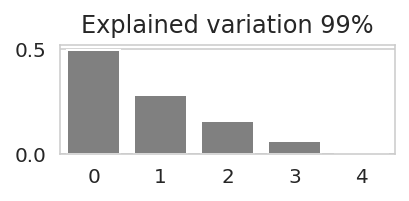

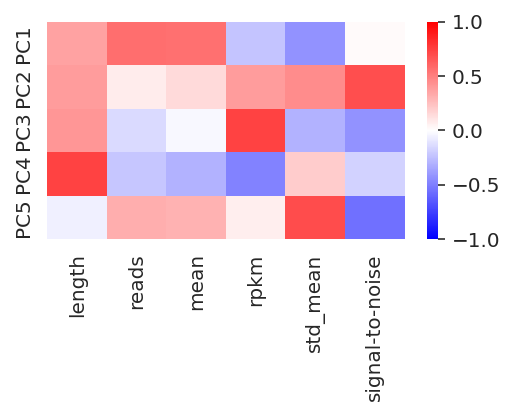

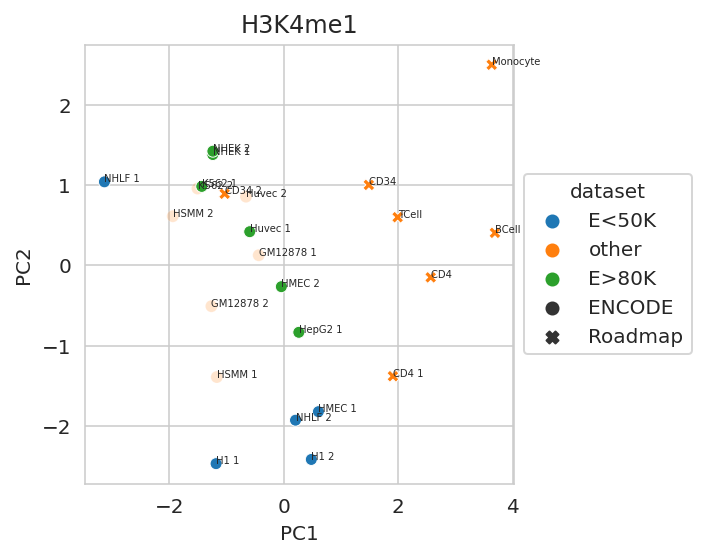

In [261]:
print('PCA of aggregated datasets')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

tt = df_aggr2[(df_aggr2['modification'] == 'H3K4me1') & (df_aggr2['tool'] == 'MACS2 broad')].copy()
# features = ['peaks', 'length', 'footprint', 'reads', 'mean', 'rpkm', 'std_mean', 'signal-to-noise']
features = ['length', 'reads', 'mean', 'rpkm', 'std_mean', 'signal-to-noise']
n = 'mle'
# n = 3
pca = PCA(n_components=n)
ttn = StandardScaler().fit_transform(tt[features]) # (n_samples x n_features)
# ttn = tt[features] # (n_samples x n_features)
result_pca = pca.fit_transform(ttn)

xs = result_pca[:, 0]
ys = result_pca[:, 1]

plt.figure(figsize=(3, 1))
plt.title(f'Explained variation {int(np.sum(pca.explained_variance_ratio_) * 100)}%')
sns.barplot(x=list(range(pca.n_components_)), y=pca.explained_variance_ratio_, color='gray')
plt.show()

rdgn = sns.diverging_palette(h_neg=130, h_pos=10, s=99, l=55, sep=3, as_cmap=True)

plt.figure(figsize=(4, 2))
sns.heatmap(pca.components_,
            cmap='bwr', vmin=-1, vmax=1,
            yticklabels=[f'PC{i + 1}' for i in range(pca.n_components_)],
            xticklabels=list(features))
plt.show()

plt.figure(figsize=(5, 4))
ax = plt.axes()
tt['ds_c_r'] = tt['dataset'] + ' ' + tt['cell'] + ' ' + tt['replicate']
sns.scatterplot(
    tt, x=xs, y=ys,
    style='dataset',
    hue=['E<50K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else 'other' for dscr in tt['ds_c_r']],
    alpha=[1 if dscr in g1_ds_c_r or dscr in g2_ds_c_r or 'Roadmap' in dscr else 0.2 for dscr in tt['ds_c_r']],
    ax = ax)
for xv, yv, cell, rep in zip(xs, ys, tt['cell'], tt['replicate']):
    rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
    ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
ax.title.set_text('H3K4me1')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.tight_layout()
plt.show()



reads vs mean


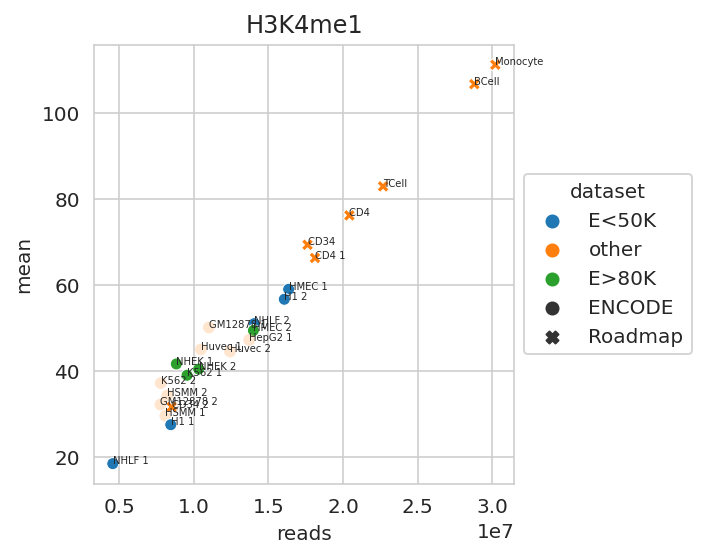



peaks vs rpkm


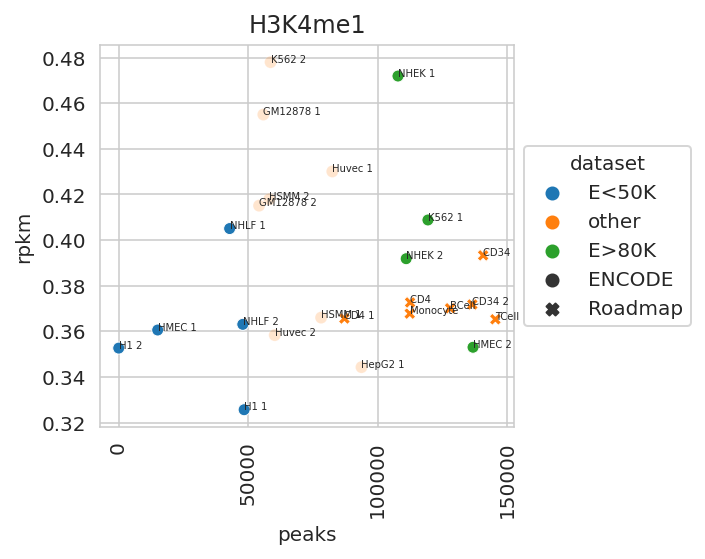



length vs rpkm


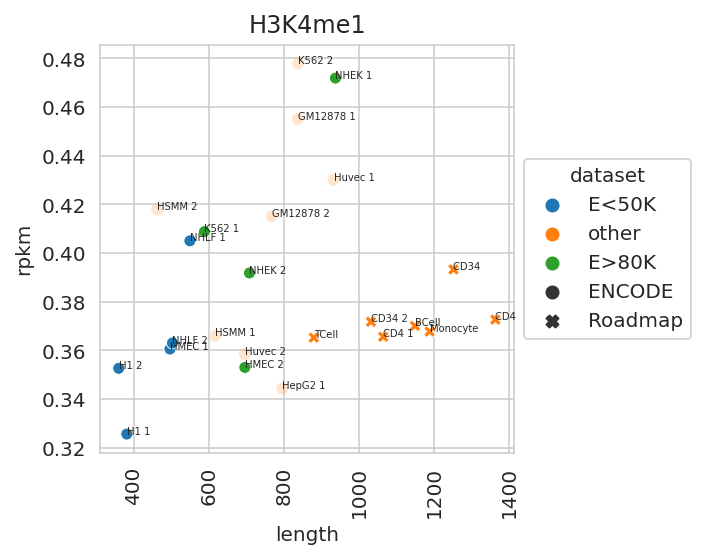



peaks vs std_mean


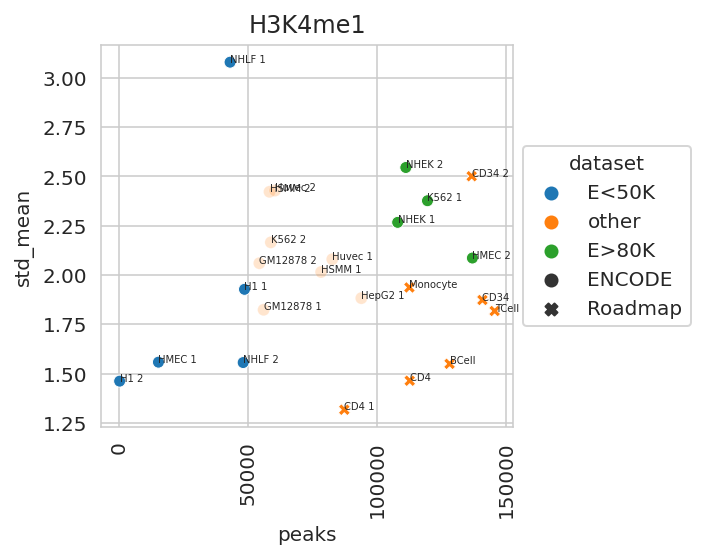



length vs std_mean


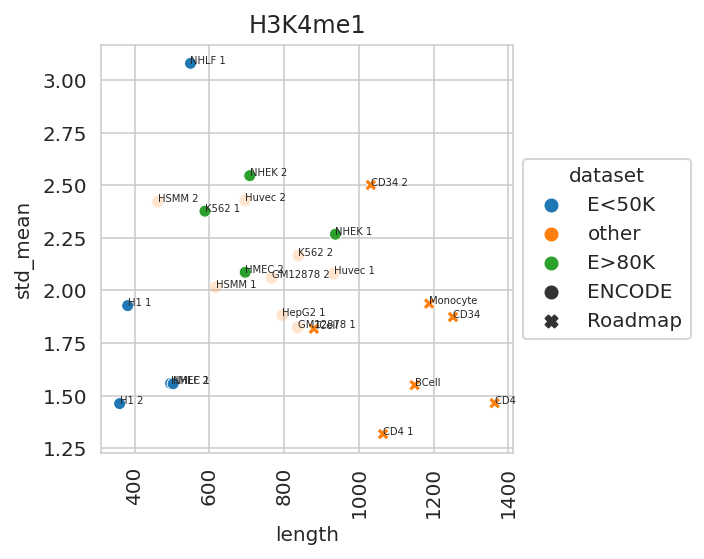



reads vs std_mean


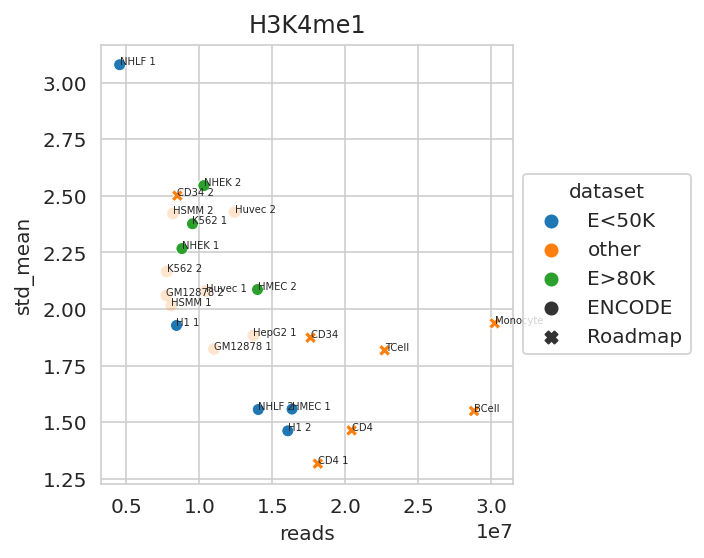



peaks vs signal-to-noise


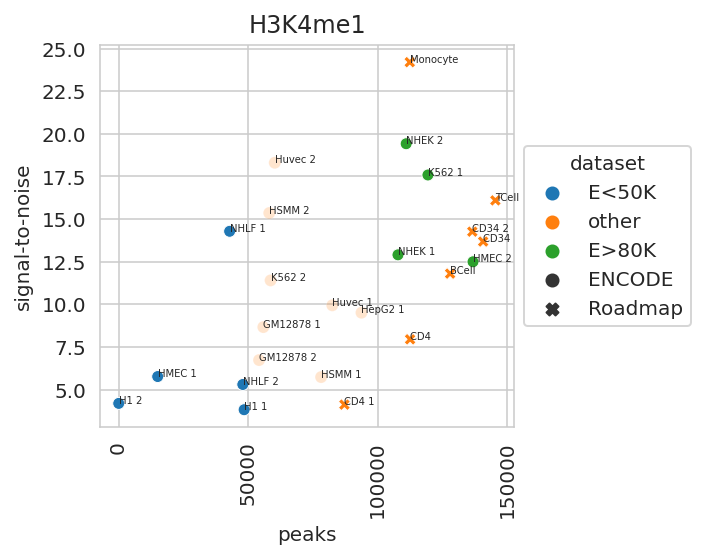



length vs signal-to-noise


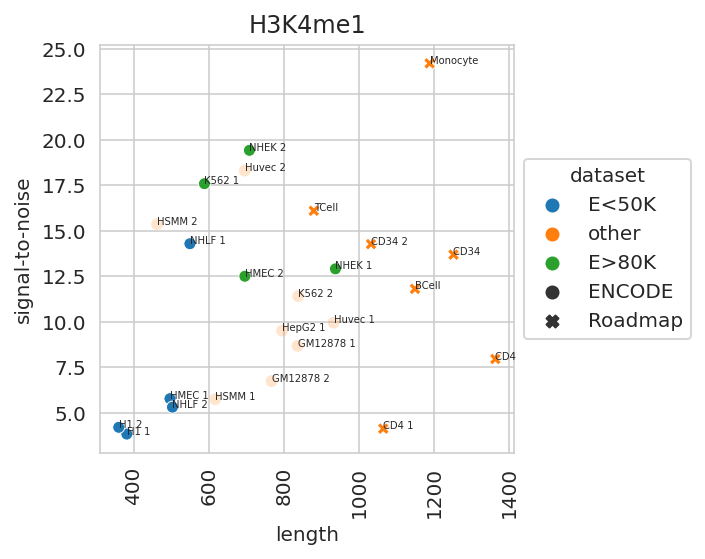



mean vs signal-to-noise


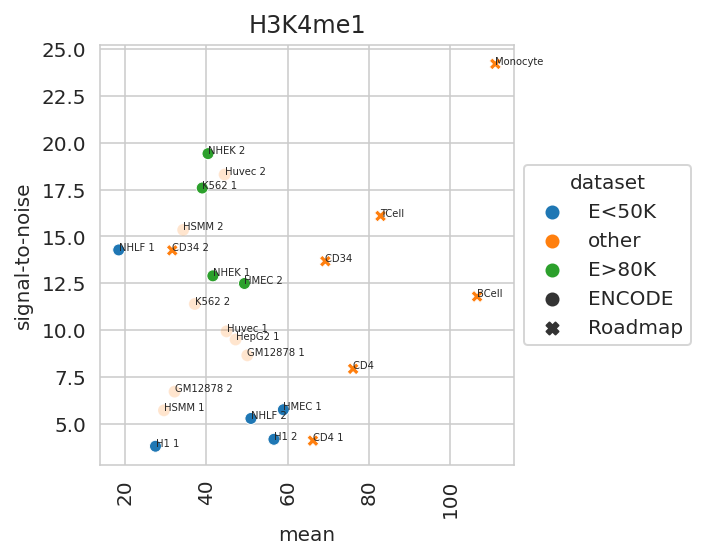



std_mean vs signal-to-noise


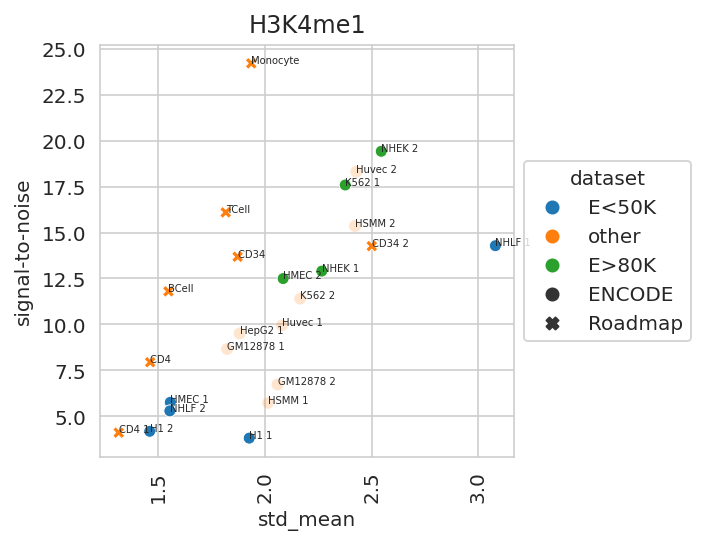

In [240]:
for x, y in [('reads', 'mean'), ('peaks', 'rpkm'), ('length', 'rpkm'), ('peaks', 'std_mean'), ('length', 'std_mean'), ('reads', 'std_mean'),
             ('peaks', 'signal-to-noise'), ('length', 'signal-to-noise'), ('mean', 'signal-to-noise'), ('std_mean', 'signal-to-noise')]:
    print(f'\n\n{x} vs {y}')
    plt.figure(figsize=(5, 4))
    ax = plt.axes()
    tt = df_aggr2[(df_aggr2['modification'] == 'H3K4me1') & (df_aggr2['tool'] == 'MACS2 broad')].copy()
    tt['ds_c_r'] = tt['dataset'] + ' ' + tt['cell'] + ' ' + tt['replicate']
    sns.scatterplot(
        tt, x=x, y=y,
        style='dataset',
        hue=['E<50K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else 'other' for dscr in tt['ds_c_r']],
        alpha=[1 if dscr in g1_ds_c_r or dscr in g2_ds_c_r or 'Roadmap' in dscr else 0.2 for dscr in tt['ds_c_r']],
        ax = ax)
    for xv, yv, cell, rep in zip(tt[x], tt[y], tt['cell'], tt['replicate']):
        rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
        ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
    ax.title.set_text(m)
    sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if x != 'reads':
        ax.xaxis.set_tick_params(rotation=90)
    plt.tight_layout()
    plt.show()

# Difference

In [179]:
def compute_diffs(df, modifications, cells, replicates):
    tools = df['tool'].unique()
    rows = []    
    tf = tempfile.mktemp()
    for m, c, r in tqdm(list(product(modifications, cells, replicates))):
        print(m, c, r)
        t = df[(df['modification'] == m) & (df['cell'] == c) & (df['replicate'] == r) & (df['tool'] == 'SPAN')]
        if len(t) == 0:
            continue
        span_file = sorted_file(t['file'].values[0])
        # Processing single tools information
        for tool in tools:
            if tool == 'SPAN':
                continue
            t = df[(df['modification'] == m) & (df['cell'] == c) & (df['replicate'] == r) & (df['tool'] == tool)]
            if len(t) == 0:
                continue
            peaks_file = sorted_file(t['file'].values[0])
            for name, args in [
                (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
                (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
                !bedtools intersect {args} -wa -v > {tf}
                peaks = lines(tf)
                rows.append((m, c, r, name, peaks))

    return pd.DataFrame(rows, columns=['modification', 'cell', 'replicate', 'name', 'peaks'])

## ENCODE

In [181]:
df_encode_diff = compute_diffs(df_encode_peaks, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_diff.sample(5)

H3K4me3


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


H3K27ac


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 23.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


H3K4me1


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 23.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 52.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserW

H3K27me3


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 23.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 52.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserW

H3K36me3


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 23.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 52.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserW

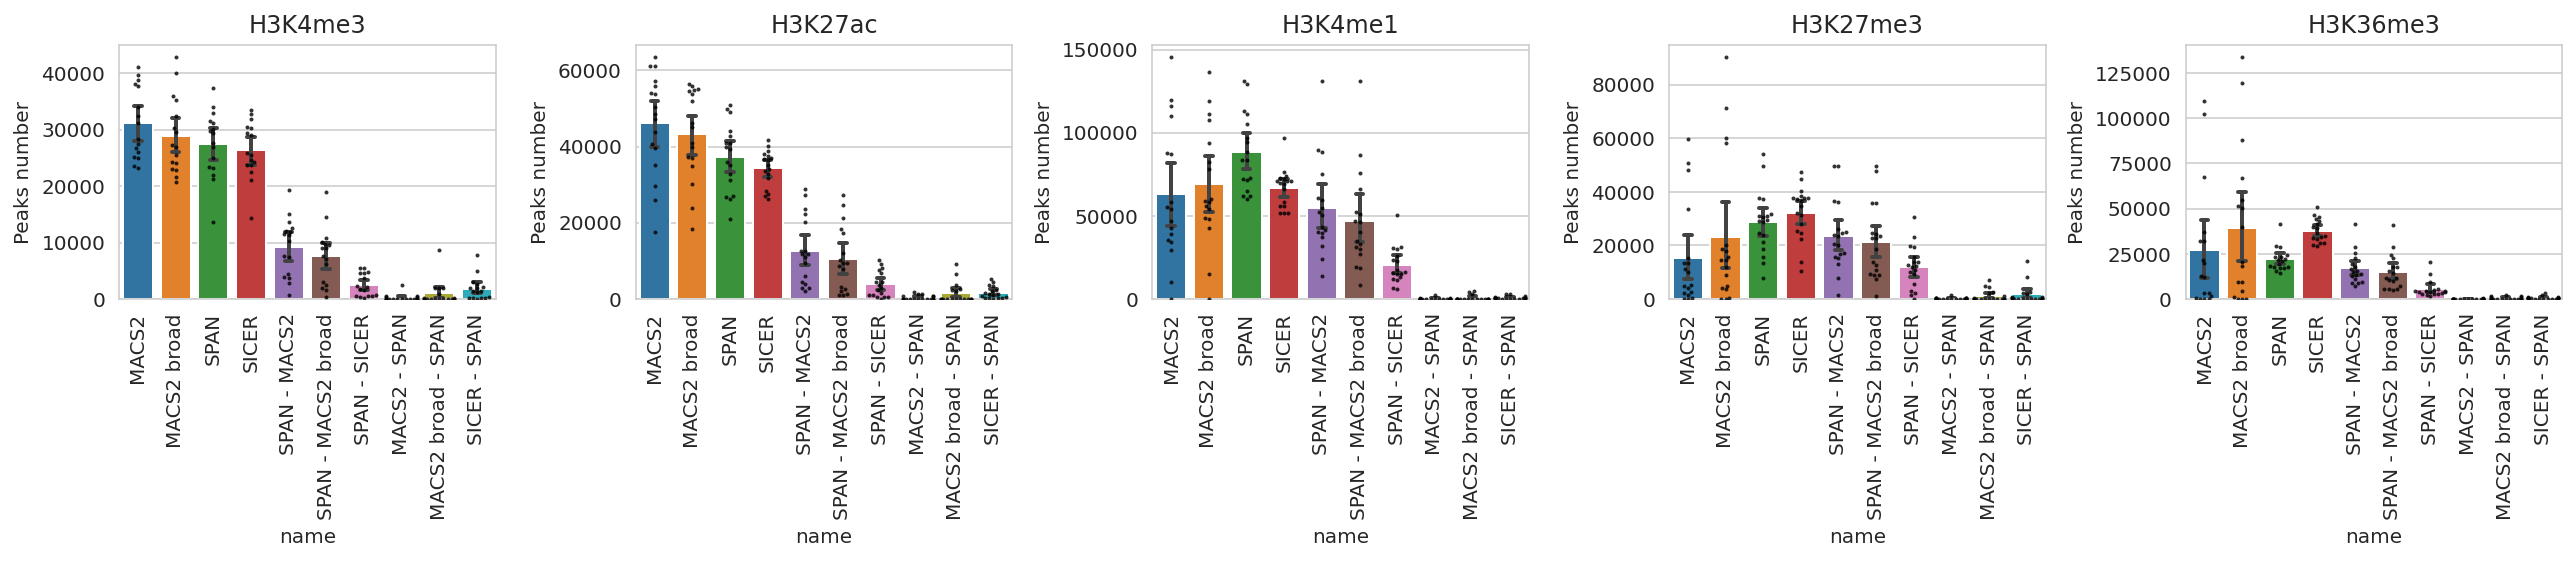

In [64]:
t = df_encode_peaks[['modification', 'cell', 'replicate', 'tool', 'peaks']].copy()
t.rename({'tool': 'name'}, axis=1, inplace=True)
t = pd.concat([t, df_encode_diff]).reset_index(drop=True)

plt.figure(figsize=(18, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]

for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    print(m)
    ax.title.set_text(m)
    sns.barplot(data=t[t['modification'] == m], x='name', y='peaks',                           
                capsize=.2, errwidth=2,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ],
                ax=ax)
    sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',
                  dodge=True, size=2, color="black", alpha=0.8,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                         'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                         'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                         ],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.show()

## Roadmap

In [65]:
df_immune_diff = compute_diffs(df_immune_peaks, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_diff.sample(5)

  0%|          | 0/180 [00:00<?, ?it/s]

H3K4me3 CD4ABT rep1
H3K4me3 CD4ABT rep2
H3K4me3 CD4ABT rep3
H3K4me3 CD4ABT 
H3K4me3 TCellBB rep1
H3K4me3 TCellBB rep2
H3K4me3 TCellBB rep3
H3K4me3 TCellBB 
H3K4me3 BCell rep1
H3K4me3 BCell rep2
H3K4me3 BCell rep3
H3K4me3 BCell 
H3K4me3 TCell rep1
H3K4me3 TCell rep2
H3K4me3 TCell rep3
H3K4me3 TCell 
H3K4me3 Monocyte rep1
H3K4me3 Monocyte rep2
H3K4me3 Monocyte rep3
H3K4me3 Monocyte 
H3K4me3 PBMC rep1
H3K4me3 PBMC rep2
H3K4me3 PBMC rep3
H3K4me3 PBMC 
H3K4me3 NK rep1
H3K4me3 NK rep2
H3K4me3 NK rep3
H3K4me3 NK 
H3K4me3 CD34 rep1
H3K4me3 CD34 rep2
H3K4me3 CD34 rep3
H3K4me3 CD34 
H3K4me3 CD4 rep1
H3K4me3 CD4 rep2
H3K4me3 CD4 rep3
H3K4me3 CD4 
H3K27ac CD4ABT rep1
H3K27ac CD4ABT rep2
H3K27ac CD4ABT rep3
H3K27ac CD4ABT 
H3K27ac TCellBB rep1
H3K27ac TCellBB rep2
H3K27ac TCellBB rep3
H3K27ac TCellBB 
H3K27ac BCell rep1
H3K27ac BCell rep2
H3K27ac BCell rep3
H3K27ac BCell 
H3K27ac TCell rep1
H3K27ac TCell rep2
H3K27ac TCell rep3
H3K27ac TCell 
H3K27ac Monocyte rep1
H3K27ac Monocyte rep2
H3K27ac Mono

UnboundLocalError: local variable 'child' referenced before assignment

In [ ]:
t = df_immune_peaks[['modification', 'cell', 'replicate', 'tool', 'peaks']].copy()
t.rename({'tool': 'name'}, axis=1, inplace=True)
t = pd.concat([t, df_immune_diff]).reset_index(drop=True)

plt.figure(figsize=(18, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]

for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    ax.title.set_text(m)
    sns.barplot(data=t[t['modification'] == m], x='name', y='peaks',
                capsize=.2, errwidth=2,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ],
                ax=ax)
    sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',
                  dodge=True, size=2, color="black", alpha=0.8,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                         'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                         'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                         ],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.show()

# Jaccard & Overlap

In [ ]:
def compute_reps_overlap(df_peaks, modifications, cells):
    reps_overlap = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2',
                                     'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                     'peaks1_overlap', 'peaks2_overlap', 'peaks_overlap_len'], dtype=object)

    tf = tempfile.mktemp()

    tools = list(sorted(set(df_peaks['tool'])))
    for m, c in tqdm(product(modifications, cells)):
        print(m, c)
        tm = df_peaks[(df_peaks['modification'] == m) & (df_peaks['cell'] == c)]
        reps = list(sorted(set(tm['replicate'])))
        for tool in tools:
            for i in range(len(reps)):
                for j in range(i + 1, len(reps)):
                    rep1, rep2 = reps[i], reps[j]
                    t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep1)]
                    t2 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep2)]
                    if len(t1) == 0 or len(t2) == 0:
                        continue
                    file1 = sorted_file(t1['file'].values[0])
                    file2 = sorted_file(t2['file'].values[0])
                    peaks1 = t1['peaks'].values[0]
                    peaks1_len = int(bedl(file1).sum())
                    peaks2 = t2['peaks'].values[0]
                    peaks2_len = int(bedl(file2).sum())
                    !bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
                    overlap1 = lines(tf)
                    !bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
                    overlap2 = lines(tf)
                    !bedtools intersect -a {file1} -b {file2} -wo > {tf}
                    overlap_len = int(last_col(tf).sum())

                    reps_overlap.loc[len(reps_overlap)] = \
                        (m, c, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                        overlap1, overlap2, overlap_len)
    reps_overlap['jaccard'] = [
        d(lo, l1 + l2 - lo)
        for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks_overlap_len'])
    ]                    
    return reps_overlap

## Jaccard ENCODE 

In [ ]:
t = df_encode_peaks.loc[[(m, c, r) not in OUTLIERS 
                         for _, (m, c, r) in df_encode_peaks[['modification', 'cell', 'replicate']].iterrows()]]
# t = df_encode_peaks
df_encode_reps = compute_reps_overlap(t, MODIFICATIONS, GSE26320_CELLS)
df_encode_reps.sample(5)

In [ ]:
print('ENCODE')
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_encode_reps, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_encode_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=3, color="black", alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.lineplot(data=df_encode_reps[df_encode_reps['modification'] == m],
                             x='cell', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             errorbar='se', marker='o', markersize=8,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
t = pd.concat([df_encode_reps[['modification', 'cell', 'tool']], 
               df_encode_reps[['modification', 'cell', 'tool']]]).reset_index(drop=True)
overlaps = [d(o, p) for o, p in zip(df_encode_reps['peaks1_overlap'], df_encode_reps['peaks1'])] + \
           [d(o, p) for o, p in zip(df_encode_reps['peaks2_overlap'], df_encode_reps['peaks2'])]
t['overlap'] = overlaps
print('ENCODE')
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False
            )
sns.swarmplot(data=t, x='modification', hue='tool', y='overlap',
              dodge=True, size=3, color="black", alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)

ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
print('ENCODE')
df_encode_reps['peaks_diff'] = np.fabs((df_encode_reps['peaks1'] - df_encode_reps['peaks2']) /
                                       (df_encode_reps['peaks1'] + df_encode_reps['peaks2']) * 200)
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.scatterplot(data=df_encode_reps[df_encode_reps['modification'] == m],
                             x='peaks_diff', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
rows = []
for _, (modification, tool, jaccard, p1, p2, l1, l2) in df_encode_reps[
    ['modification', 'tool', 'jaccard', 'peaks1', 'peaks2', 'peaks1_len', 'peaks2_len']].iterrows():
    rows.append((modification, tool, jaccard, d(l1, p1)))
    rows.append((modification, tool, jaccard, d(l2, p2)))
df_jaccard_avg_len_encode = pd.DataFrame(rows, columns=['modification', 'tool', 'jaccard', 'average_len'])
del rows

In [ ]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.scatterplot(
        df_jaccard_avg_len_encode[df_jaccard_avg_len_encode['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax = ax,
        # fill=True
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(5, 3))
    ax = plt.axes()
    sns.scatterplot(
        df_jaccard_avg_len_encode[df_jaccard_avg_len_encode['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax = ax,
        # fill=True
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    ax.set_ylabel('average length')
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

## Jaccard Roadmap

In [ ]:
t = df_immune_peaks.loc[[(m, c, r) not in OUTLIERS 
                         for _, (m, c, r) in df_immune_peaks[['modification', 'cell', 'replicate']].iterrows()]]
# t = df_immune_peaks
df_immune_reps = compute_reps_overlap(t, MODIFICATIONS, IMMUNE_CELLS)
df_immune_reps.sample(5)

In [ ]:
print('Immune')
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_immune_reps, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=df_immune_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=3, color="black", alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.lineplot(data=df_immune_reps[df_immune_reps['modification'] == m],
                             x='cell', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             errorbar='se', marker='o', markersize=8,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
print('Immune')
t = pd.concat([df_immune_reps[['modification', 'cell', 'tool']],
               df_immune_reps[['modification', 'cell', 'tool']]]).reset_index(drop=True)
overlaps = [d(o, p) for o, p in zip(df_immune_reps['peaks1_overlap'], df_immune_reps['peaks1'])] + \
           [d(o, p) for o, p in zip(df_immune_reps['peaks2_overlap'], df_immune_reps['peaks2'])]
t['overlap'] = overlaps
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=t, x='modification', hue='tool', y='overlap',
              dodge=True, size=3, color="black", alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)

ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
df_immune_reps['peaks_diff'] = np.fabs((df_immune_reps['peaks1'] - df_immune_reps['peaks2']) / 
                                       (df_immune_reps['peaks1'] + df_immune_reps['peaks2']) * 200)

plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.scatterplot(data=df_immune_reps[df_immune_reps['modification'] == m],
                                x='peaks_diff', y='jaccard', hue='tool',
                                hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                                palette=TOOLS_PALETTE,
                                ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
rows = []
for _, (modification, tool, jaccard, p1, p2, l1, l2) in df_immune_reps[
    ['modification', 'tool', 'jaccard', 'peaks1', 'peaks2', 'peaks1_len', 'peaks2_len']].iterrows():
    rows.append((modification, tool, jaccard, d(l1, p1)))
    rows.append((modification, tool, jaccard, d(l2, p2)))
df_jaccard_avg_len_immune = pd.DataFrame(rows, columns=['modification', 'tool', 'jaccard', 'average_len'])
del rows

In [ ]:

plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.scatterplot(
        df_jaccard_avg_len_immune[df_jaccard_avg_len_immune['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax = ax,
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
    #     Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
STOP

# IDR

In [ ]:
def compute_reps_idr(df_peaks, modifications, cells):
    reps_idr = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2', 'peaks1', 'peaks2', 
                                     'idr_loaded_peaks1', 'idr_loaded_peaks2', 'idr_peaks', 'idr_loaded_peaks', 'idr_percentage'
                                     ], dtype=object)

    tf = tempfile.mktemp()
    tf1 = tempfile.mktemp()
    tf2 = tempfile.mktemp()

    tools = list(sorted(set(df_peaks['tool'])))
    for m, c in tqdm(list(product(modifications, cells))):
        print(m, c)
        tm = df_peaks[(df_peaks['modification'] == m) & (df_peaks['cell'] == c)]
        reps = list(sorted(set(tm['replicate'])))
        for tool in tools:
            for i in range(len(reps)):
                for j in range(i + 1, len(reps)):
                    rep1, rep2 = reps[i], reps[j]
                    t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep1)]
                    t2 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep2)]
                    if len(t1) == 0 or len(t2) == 0:
                        continue
                    try:
                        file1 = t1['file'].values[0]
                        file2 = t2['file'].values[0]
                        print(tool, file1, file2)
                        peaks1 = t1['peaks'].values[0]
                        peaks2 = t2['peaks'].values[0]
                        # Process SICER peaks, add missing 8th column, as -log10 qvalue
                        if tool == 'SICER':
                            sf1 = pd.read_csv(file1, sep='\t', header=None)
                            sf1[8] = -np.log10(sf1[7])
                            sf1.to_csv(tf1, sep='\t', index=None, header=False)
                            file1 = tf1
                            sf2 = pd.read_csv(file2, sep='\t', header=None)
                            sf2[8] = -np.log10(sf2[7])
                            sf2.to_csv(tf2, sep='\t', index=None, header=False)
                            file2 = tf2
                        ! idr --input-file-type bed --rank 8 --samples {file1} {file2} 2>&1 | tee {tf}
                        with open(tf) as f:
                            idr_out = f.read()
                        # print('IDR OUT', tf, idr_out)
                        lp1, lp2 = re.findall('Number of reported peaks - (\\d+)/(\\d+)', idr_out)[0]
                        lp1, lp2 = int(lp1), int(lp2)
                        ip, ilp, iperc = re.findall('Number of peaks passing IDR cutoff of 0.05 - (\\d+)/(\\d+) \\(([\\d\\.]+)', idr_out)[0]
                        ip, ilp, iperc = int(ip), int(ilp), float(iperc)
                        print(m, c, tool, rep1, rep2, peaks1, peaks2, lp1, lp2, ip, ilp, iperc)
                        reps_idr.loc[len(reps_idr)] = \
                            (m, c, tool, rep1, rep2, peaks1, peaks2, lp1, lp2, ip, ilp, iperc)
                    except Exception as e:
                        # raise e
                        # print(e)
                        pass  # Ignore errors for now
    return reps_idr

## IDR ENCODE

In [ ]:
# t = df_encode_peaks.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in df_encode_peaks[['modification', 'cell', 'replicate']].iterrows()]]
t = df_encode_peaks
df_encode_idr_reps = compute_reps_idr(t, MODIFICATIONS, GSE26320_CELLS)
df_encode_idr_reps.sample(5)

In [ ]:
print('ENCODE')
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_encode_idr_reps, x='modification', hue='tool', y='idr_percentage',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR %')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_encode_idr_reps, x='modification', hue='tool', y='idr_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_encode_idr_reps, x='modification', hue='tool', y='idr_loaded_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR loaded peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
for m in MODIFICATIONS:
    plt.figure(figsize=(6, 2))
    g_result = sns.boxplot(data=df_encode_idr_reps[df_encode_idr_reps['modification'] == m], 
                           x='idr_peaks', y = 'tool',
                           palette=TOOLS_PALETTE,
                           order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                           )
    ax = g_result.axes
    ax.set_title(f'IDR between {m} replicates')
    ax.set_ylabel('Tool')
    ax.set_xlabel('IDR peaks')
    plt.tight_layout()
    plt.show()

In [ ]:
plt.figure(figsize=(10, 2))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    t = df_encode_idr_reps[df_encode_idr_reps['modification'] == m]
    g_results = sns.scatterplot(data=t,
                                x='idr_peaks', y='idr_percentage',
                                hue='tool',
                                palette=TOOLS_PALETTE,
                                alpha=0.8,
                                ax=ax,
                                )
    for x, y, cell in zip(t['idr_peaks'], t['idr_percentage'], t['cell']):
        ax.text(x, y, cell, fontsize = 4)
    ax.title.set_text(m)
    if i != 0:
        ax.set_ylabel(None)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

## IDR Roadmap

In [ ]:
# t = df_immune_peaks.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in df_immune_peaks[['modification', 'cell', 'replicate']].iterrows()]]
t = df_immune_peaks
df_immune_idr_reps = compute_reps_idr(t, MODIFICATIONS, IMMUNE_CELLS)
df_immune_idr_reps.sample(5)

In [ ]:
print('Immune')
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_immune_idr_reps, x='modification', hue='tool', y='idr_percentage',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR %')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
print('Immune')
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_immune_idr_reps, x='modification', hue='tool', y='idr_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_immune_idr_reps, x='modification', hue='tool', y='idr_loaded_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR loaded peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
for m in MODIFICATIONS:
    plt.figure(figsize=(6, 2))
    g_result = sns.boxplot(data=df_immune_idr_reps[df_immune_idr_reps['modification'] == m],
                           x='idr_peaks', y = 'tool',
                           palette=TOOLS_PALETTE,
                           order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                           )
    ax = g_result.axes
    ax.set_title(f'IDR between {m} replicates')
    ax.set_ylabel('Tool')
    ax.set_xlabel('IDR peaks')
    plt.tight_layout()
    plt.show()

In [ ]:
plt.figure(figsize=(10, 2))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    t = df_immune_idr_reps[df_immune_idr_reps['modification'] == m]
    g_results = sns.scatterplot(data=t,
                    x='idr_peaks', y='idr_percentage',
                    hue='tool',
                    palette=TOOLS_PALETTE,
                    alpha=0.8,
                    ax=ax,
                    )
    for x, y, cell in zip(t['idr_peaks'], t['idr_percentage'], t['cell']):
        ax.text(x, y, cell, fontsize = 4)    
    ax.title.set_text(m)
    if i != 0:
        ax.set_ylabel(None)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()